<a href="https://www.kaggle.com/code/yannicksteph/179-rsna-miccai-brain-tumor-classification?scriptVersionId=133883185" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/yannicksteph/rsna-miccai-brain-tumor-classification" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🚧 Work in progress 🚧 #

**<center><font size=5>RSNA-MICCAI Brain Tumor Classification</font></center>**

<center><img src="https://lingualab.ca/fr/project/language-recovery-psa/featured_hu67ab33455cf328a3b8dbb37d23762824_484672_720x0_resize_lanczos_2.png" alt="equal-2495950-1920" border="0" width="700"></center>

****

# 🚧 TODO TEAM / Na pas oublier de mettre les sections ⚠️

**Table of Contents**
- <a href='#overview'>1. Project overview and objectives</a> 
    - <a href='#contributors'>1.1. Contributors</a>
    - <a href='#dataset_overview'>1.2. Data overview</a>
    - <a href='#definitions'>1.3. Imports, Methods, Paths, Reading definitions</a>
- <a href='#exploratory_data'>2. Exploratory Data</a>
    - <a href='#exploratory_data_2_1'>2.1. MRI  scans folders</a>
    - <a href='#exploratory_data_2_2'>2.2. MRI slides scans previews</a>
    - <a href='#exploratory_data_2_3'>2.3. MRI and MGMT values previews</a>
- <a href='#brain_segmentation'>3. Brain segmentation</a>
    - <a href='#brain_segmentation_3_1'>3.1. Importance of Brain Segmentation</a>
    - <a href='#brain_segmentation_3_2'>3.2. Selection Criteria</a>
    - <a href='#brain_segmentation_3_3'>3.3. Contributions of the Library</a>
- <a href='#utilizing_unet_4'>4. Utilizing the U-Net for Brain MRI Model and RadiomicsShape2D Class</a>
    - <a href='#utilizing_unet_4_1'>4.1. Architecture</a>
    - <a href='#utilizing_unet_4_2'>4.2. Usage Instructions</a>
    - <a href='#utilizing_unet_4_3'>4.3. RadiomicsShape2D Class</a>
    - <a href='#utilizing_unet_4_4'>4.4. Usage Instructions</a>
- <a href='#dataset_creation_5'>5. Dataset creation</a>
- <a href='#exploratory_dataset'>6. Exploratory Dataset</a>
- <a href='#analysis'>7. Analysis Dataset</a>
    - <a href='#analysis_7_1'>7.1. Average Patient MGMT Comparison</a> 
    - <a href='#analysis_7_2'>7.2. Correlation Matrix</a> 
    - <a href='#analysis_7_3'>7.3. Univariate analysis</a>  
    - <a href='#analysis_7_4'>7.4. Bivariate analysis</a>           
- <a href='#clean_preprocessing_8'>8. Clean & Preprocessing</a>


****

# <a id='overview'>1. Project overview and objectives</a>

### Overview:

A malignant brain tumor is a life-threatening condition, specifically glioblastoma, which is the most common and has the poorest prognosis among adult brain cancers, with a median survival of less than a year. The presence of a specific genetic sequence called MGMT promoter methylation in the tumor has been identified as a favorable prognostic factor and a strong predictor of chemotherapy responsiveness.

Currently, the genetic analysis of cancer requires a surgical procedure to obtain a tissue sample, followed by a time-consuming process of determining the genetic characteristics of the tumor, which can take several weeks. Depending on the results and the chosen initial treatment, additional surgeries may be necessary. Developing an accurate method to predict the genetic profile of the cancer solely through imaging (known as radiogenomics) would potentially reduce the number of surgeries and allow for a more tailored therapy approach.

The Radiological Society of North America (RSNA) and the Medical Image Computing and Computer Assisted Intervention Society (MICCAI Society) have collaborated to enhance the diagnosis and treatment planning for glioblastoma patients.

### Competition:

In this competition, participants are tasked with using MRI (magnetic resonance imaging) scans to train and test a model that can predict the genetic subtype of glioblastoma by detecting the presence of MGMT promoter methylation.

Successful outcomes from this competition could significantly contribute to less invasive diagnoses and treatments for brain cancer patients. Introducing new and personalized treatment strategies before surgery holds the potential to improve the management, survival rates, and overall prospects of individuals affected by brain cancer.

### Acknowledgments:

The Radiological Society of North America (RSNA®) is a non-profit organization representing 31 radiologic subspecialties from 145 countries worldwide. RSNA promotes excellence in patient care and healthcare delivery through education, research, and technological innovation.

RSNA provides high-quality educational resources, publishes five top peer-reviewed journals, hosts the world's largest radiology conference, and is dedicated to shaping the future of the profession through the RSNA Research & Education (R&E) Foundation, which has funded $66 million in grants since its establishment. Additionally, RSNA actively supports and facilitates research in medical imaging artificial intelligence (AI) by sponsoring ongoing AI challenge competitions.

The Medical Image Computing and Computer Assisted Intervention Society (MICCAI Society) is committed to advancing research, education, and practice in the field of medical image computing, computer-assisted interventions, biomedical imaging, and medical robotics. The society achieves this objective by organizing high-quality international conferences, workshops, tutorials, and publications that promote the exchange and dissemination of advanced knowledge, expertise, and experiences produced by leading institutions, scientists, physicians, and educators worldwide.

A complete list of acknowledgments can be found on this page.

[RSNA-MICCAI Brain Tumor Radiogenomic Classification](https://www.kaggle.com/competitions/rsna-miccai-brain-tumor-radiogenomic-classification/data?select=train_labels.csv)

## <a id='contributors'>1.1. Contributors</a>

- [David Goudard](https://www.kaggle.com/goudgoud)
- [Louis-Marie Renaud](https://www.kaggle.com/louismarierenaud)
- [Yannick Stephan](https://github.com/YanSteph)


## <a id='contributors'>1.2. Note & Global</a>

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
   <div class="card-body">
      <h2 class="card-title" style="color: white;"><strong>📝 Note:</strong></h2>
      <p style="color: white;">
         This "Note" block contains information and conclusions based on the analysis of previous results.<br>It provides important remarks and points to consider for proper interpretation of the data and conclusions drawn.
      </p>
   </div>
</div>
<br>
<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
   <div class="card-body">
      <h2 class="card-title" style="color: white;"><strong>🛠 Global:</strong></h2>
      <p style="color: white;">
         This "Global" block contains global information and settings relevant to the project.<br>It provides details on the configuration and global aspects to consider when analyzing data and developing models.
      </p>
   </div>
</div>

## <a id='contributors'>1.3. Abbreviations List</a>

- **ADC** : Apparent Diffusion Coefficient
- **ASL** : Arterial Spin Labelling
- **AUC** : Area Under the Curve 
- **DSC** : Dynamic Susceptibility Contrast 
- **DTI** : Diffusion-Tensor Imaging 
- **DWI** : Diffusion-Weighted Imaging 
- **FLAIR** : Fluid-attenuated Inversion Recovery
- **GLCM** : Gray Level Co-occurrence Matrix
- **GLRLM** : Grey Level Run-Length Matrix 
- **MD** : Mean Diffusivity
- **MNI** : Montreal Neurological Institute
- **ROC** : Receiver Operating Characteristic
- **ROI**: Region Of Interest

## <a id='definitions'>1.4. Imports, Methods, Paths, Reading definitions</a>

### Imports

In [62]:
# Operating System and File System
import os 

# Basic
import math
from enum import Enum
from itertools import chain

# Data Manipulation and Analysis
import numpy as np  
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt 
# Animation Matplotlib
import matplotlib.animation as anim
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

# Warnings
import warnings  # For suppressing warnings

# JSON Handling
import json  # For working with JSON data

# Encoding and Decoding Binary Data
import base64  # For encoding and decoding binary data

# Interactive Widgets and Display
import ipywidgets as widgets  # For creating interactive widgets in Jupyter Notebook
from IPython.display import HTML, display  # For displaying HTML content
from IPython.display import Image as show_gif # GIF

# Deep Learning Framework
import torch  # For working with PyTorch deep learning framework

# DICOM File Handling
import pydicom  # For reading DICOM files
from pydicom import dcmread  # For reading DICOM files

# Image Processing and Filtering
import SimpleITK as sitk  # For image filtering
from PIL import Image  # For image processing using the Python Imaging Library (PIL)

# Machine Learning and Data Splitting
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets

from scipy import stats
from statsmodels.stats.diagnostic import lilliefors
import statsmodels.api as sm

import itertools  
from itertools import permutations

# sklearn
from sklearn.feature_selection import RFE
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# scipy
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster, linkage

# Additional Libraries
import glob # Fetch data recusif
import random

!pip install pyradiomics > /dev/null  # Installing the pyradiomics library for radiomics feature extraction
import radiomics  # For extracting radiomics features from medical images

### Paths

In [63]:
# ------------------------------------#    
# Definition Version
# ------------------------------------#    

class DatasetVersion(Enum):
    V_2D = '2D'
    V_3D = '3D'
    
# ------------------------------------#  
# Paths
# ------------------------------------#  
    
# ------------#
# Folders
# ------------# 
base_folder_path = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/"
train_folder_path = f"{base_folder_path}train/"
dataset_folder_path = "../input/githut-rsna-miccai-brain-tumor-classification-ai/dataset/"

# ------------#
# Train / files
# ------------# 
train_labels_path = f"{base_folder_path}train_labels.csv"
submission_labels_path = f"{base_folder_path}sample_submission.csv"

dataset_3d_path = f"{dataset_folder_path}3d_rsna_miccai_brain_tumor_brain_segmentation_pytorch_unet.csv"
dataset_2d_path = f"{dataset_folder_path}2d_rsna_miccai_brain_tumor_brain_segmentation_pytorch_unet.csv"

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>🛠 Global:</strong></h2>
        <ul>
            <li>Train folder of RSNA: <b>`train_folder_path`</b></li>
            <li>Generated Train labels Segmentation 3D CSV: <b>`train_labels_path`</b></li>
        </ul>
    </div>
</div>

### Constants

In [64]:
# ------------------------------------#   
# Configuration
# ------------------------------------#    
    
# ℹ️ Flag to skip brain segmentation with PyTorch UNet
# If set to True, we will import the dataset that has already been generated
skip_brain_segmentation_pytorch_unet = True

# ℹ️ Set the dataset version to use when <skip_brain_segmentation_pytorch_unet = True>
dataset_version =  DatasetVersion.V_3D

#Color
default_palette_color = "deep"

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>🛠 Global:</strong></h2>
        <ul>
            <li>Flag to skip brain segmentation with PyTorch UNet: <b>`skip_brain_segmentation_pytorch_unet`</b></li>
            <li>Flag to set the dataset version 2D or 3D: <b>`dataset_version`</b></li>
            <li>👆🏻 Configuration of the project</li>
        </ul>
    </div>
</div>


### Configure

In [65]:
# ------------------------------------#
# Configuration options
# ------------------------------------#

# Pandas configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
pd.set_option('display.max_rows', None)

# Suppressing Warnings
warnings.filterwarnings('ignore')

# Define "reader"
# Read serie of image files into a SimpleTK image
sitk_reader = sitk.ImageSeriesReader()
sitk_reader.LoadPrivateTagsOn()

# Suppressing warnings SimpleITK
sitk.ProcessObject.SetGlobalWarningDisplay(False)

# Default color
sns.set_theme(palette=default_palette_color)

# ------------
# Segmentation
# ------------

# Load mateuszbuda/brain-segmentation-pytorch, U-Net with batch normalization for biomedical image segmentation with pretrained weights for abnormality segmentation in brain MRI
segmentation_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 
                                    'unet', 
                                    in_channels=3, 
                                    out_channels=1, 
                                    init_features=32, 
                                    pretrained=True, 
                                    trust_repo=True)

# ------------
# Dataset
# ------------
# Dataset of the project, explanation in next section.    
preview_dataset_df = pd.read_csv(train_labels_path)
samp_subm = pd.read_csv(submission_labels_path)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>🛠 Global:</strong></h2>
        <ul>
            <li>Dataset of the competition: <b>`preview_dataset_df`</b></li>
        </ul>
    </div>
</div>


### Methods

In [66]:
# ===============================================
# Base methods
# ===============================================

def is_even(nombre):
    return nombre % 2 == 0

def map_dataframe_to_tuples(df, columns):
    mapped_tuples = []
    for row in df.itertuples(index=False):
        mapped_tuple = tuple(getattr(row, col) for col in columns)
        mapped_tuples.append(mapped_tuple)
    return mapped_tuples

def extract_number_from_filename(filename):
    # Extrayez les chiffres à la fin du nom de fichier
    number_str = ''.join(filter(str.isdigit, filename))
    if number_str:
        return int(number_str)
    else:
        return -1  # Si aucun chiffre n'est trouvé, renvoyez une valeur par défaut
    import os
    
def remove_values(values_to_remove, source_array):
    """
    Removes elements from the source_array that are present in the values_to_remove.
    
    Args:
        values_to_remove (list): The array containing the values to be removed.
        source_array (list): The source array containing the values.

    
    Returns:
        list: The source array with the matching values removed.
    """
    for value in values_to_remove:
        if value in source_array:
            source_array.remove(value)
    return source_array

# ===============================================
# Images methods
# ===============================================

def get_processed_image(patient_id, dataset_version):
    """
    Retrieves and processes the images for a given patient, grouping them for segmentation.

    Args:
        patient_id (str): The ID of the patient (BraTS21ID).

    Returns:
        numpy.ndarray: A processed image composed of the different images of the patient.
    """
    # SEGMENTATION MODEL LIMITED TO 3 LAYERS
    # T2W SKIPPED
    patient_id = int(patient_id)

    # Paths for image sequences
    t1w_path = f'{train_folder_path}/{str(patient_id).zfill(5)}/T1w'
    #t2w_path = f'{train_folder_path}/{str(patient_id).zfill(5)}/T2w'

    flair_path = f'{train_folder_path}/{str(patient_id).zfill(5)}/FLAIR'
    t1wce_path = f'{train_folder_path}/{str(patient_id).zfill(5)}/T1wCE'

    # Retrieve image sequences
    if dataset_version == DatasetVersion.V_2D:
        t1w_image = sequence_filenames(t1w_path)
        flair_image = sequence_filenames(flair_path)
        t1wce_image = sequence_filenames(t1wce_path)
        t2w_image = None
    else:
        t1w_image = sequence_filenames(t1w_path)
        flair_image = sequence_filenames(flair_path)
        t1wce_image = sequence_filenames(t1wce_path)
        t2w_image = None
        
    # Resampling
    if dataset_version == DatasetVersion.V_2D:
        re_sampled_flair = re_sample_image(flair_image, t1w_image)
        re_sampled_t1wce = re_sample_image(t1wce_image, t1w_image)
        t2w_array = None
    else:
        re_sampled_flair = re_sample_image(flair_image, t1w_image)
        re_sampled_t1wce = re_sample_image(t1wce_image, t1w_image)
        t2w_array = None

    
    # Normalization
    if dataset_version == DatasetVersion.V_2D:
        t1w_array = normalize(sitk.GetArrayFromImage(t1w_image))
        re_sampled_flair_array = normalize(sitk.GetArrayFromImage(re_sampled_flair))
        re_sampled_t1wce_array = normalize(sitk.GetArrayFromImage(re_sampled_t1wce))
        re_sampled_t2w_array = None
    else:
        t1w_array = normalize(sitk.GetArrayFromImage(t1w_image))
        re_sampled_flair_array = normalize(sitk.GetArrayFromImage(re_sampled_flair))
        re_sampled_t1wce_array = normalize(sitk.GetArrayFromImage(re_sampled_t1wce))
        re_sampled_t2w_array = None

    # Stack sequences
    if dataset_version == DatasetVersion.V_2D:
        sequence_stacked = np.stack([t1w_array, re_sampled_flair_array, re_sampled_t1wce_array])
        central_slice = t1w_array.shape[0] // 2
    else:
        sequence_stacked = np.stack([t1w_array, re_sampled_flair_array, re_sampled_t1wce_array])
        central_slice = t1w_array.shape[0] // 2

    rvb = sequence_stacked[:, central_slice, :, :].transpose(1, 2, 0)
    image = Image.fromarray((rvb * 255).astype(np.uint8))
    return np.array([np.moveaxis(np.array(image.resize((256, 256))), -1, 0)])


    
def sequence_filenames(path) :
    """
    Retrieves a sequence of images for a given directory.

    Args:
        path (str): The path to the directory containing the DICOM data set.

    Returns:
        SimpleITK.Image: A sequence of images corresponding to the DICOM files in the directory.

    Raises:
        FileNotFoundError: If the specified path does not exist.
    """
    filenames = sitk_reader.GetGDCMSeriesFileNames(path)
    sitk_reader.SetFileNames(filenames)
    image = sitk_reader.Execute()
    
    return image    

def normalize(dataset) :
    """
    Normalizes the data obtained from the images.

    Args:
        dataset (numpy.ndarray): The dataset to be normalized.

    Returns:
        numpy.ndarray: The normalized dataset.
    """
    return (dataset - np.min(dataset)) / (np.max(dataset) - np.min(dataset))


def re_sample_image(image, ref_img):
    """
    Resamples the image to match the dimensions and properties of the reference image.

    Args:
        image (SimpleITK.Image): The image to be resampled.
        ref_img (SimpleITK.Image): The reference image used for resampling.

    Returns:
        SimpleITK.Image: The resampled image.
    """
    re_sampler = sitk.ResampleImageFilter()
    re_sampler.SetReferenceImage(ref_img)
    re_sampler.SetDefaultPixelValue(image.GetPixelIDValue())
    re_sampler.SetInterpolator(sitk.sitkLinear)
    re_sampler.SetOutputSpacing(ref_img.GetSpacing())
    re_sampler.SetOutputDirection(ref_img.GetDirection())
    re_sampler.SetOutputOrigin(ref_img.GetOrigin())
    re_sampler.SetSize(ref_img.GetSize())
    re_sampler.SetTransform(sitk.AffineTransform(image.GetDimension()))
    re_sampled_image = re_sampler.Execute(image)
    
    return re_sampled_image

def segmentation_process(image_resized):
    """
    Obtains the segmented image.

    Args:
        image_resized (numpy.ndarray): The resized image.

    Returns:
        numpy.ndarray: The segmented image.
    """
    segmentation = segmentation_model(torch.Tensor(image_resized))
    return segmentation
    
# ===============================================
# Dataset creation methods
# ===============================================

def init_dataset_radiomics() :
    """
    Initializes the DataFrame structures for radiomics data acquisition.

    Returns:
        None
    """
    global df_shapes
    global df_textures
    global df_first_orders_features
    
    if dataset_version == DatasetVersion.V_3D:
        df_shapes_columns = ['ID','BraTS21ID','MeshVolume','VoxelVolume','SurfaceArea','SurfaceVolumeRatio','Sphericity',
                             'Compactness1','Compactness2','SphericalDisproportion','Maximum3DDiameter','Maximum2DDiameterRow',
                             'Maximum2DDiameterColumn','MajorAxisLength','MinorAxisLenth','LeastAxisLength','Elongation','Flatness']

    else :
        df_shapes_columns = ['ID','BraTS21ID','MeshSurface','PixelSurface','Perimeter','PerimeterSurfaceRatio','Sphericity',
                             'SphericalDisproportion','MaximumDiameter','MajorAxisLength','MinorAxisLenth','Elongation']

    
    df_shapes = pd.DataFrame(columns=df_shapes_columns) 

    # GLCM features
    df_textures_columns = ['ID','Autocorrelation', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 
                           'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'Id', 'Idm', 
                           'Idmn', 'Idn', 'Imc1', 'Imc2', 'InverseVariance', 'JointAverage', 'JointEnergy', 'JointEntropy', 
                           'MCC', 'MaximumProbability', 'SumAverage', 'SumEntropy', 'SumSquares']
    df_textures = pd.DataFrame(columns=df_textures_columns) 


    # FIRST ORDERS features
    df_first_orders_features_columns=['ID','10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis', 
                                      'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median', 'Minimum', 'Range', 'RobustMeanAbsoluteDeviation', 
                                      'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Uniformity', 'Variance']
    df_first_orders_features = pd.DataFrame(columns=df_first_orders_features_columns) 

    # gzlm features
    df_gzlm_features_columns = ['ID','SmallAreaEmphasis','LargeAreaEmphasis','GrayLevelNonUniformity','GrayLevelNonUniformityNormalized',
                                'SizeZoneNonUniformity','SizeZoneNonUniformityNormalized','ZonePercentage','GrayLevelVariance','ZoneVariance',
                                'ZoneEntropy','LowGrayLevelZoneEmphasis','HighGrayLevelZoneEmphasis','SmallAreaLowGrayLevelEmphasis',
                                'SmallAreaHighGrayLevelEmphasis','LargeAreaLowGrayLevelEmphasis','LargeAreaHighGrayLevelEmphasis']
    df_gzlm_features = pd.DataFrame(columns=df_gzlm_features_columns)
    
    #glrlm_features
    df_glrlm_features_columns = ['ID','ShortRunEmphasis','LongRunEmphasis','GrayLevelNonUniformity','RunLengthNonUniformity','RunLengthNonUniformityNormalized'
                                 ,'RunPercentage','GrayLevelVariance','RunVariance','RunEntropy','LowGrayLevelRunEmphasis','HighGrayLevelRunEmphasis'
                                 ,'ShortRunLowGrayLevelEmphasis','ShortRunHighGrayLevelEmphasis','LongRunLowGrayLevelEmphasis','LongRunHighGrayLevelEmphasis']
    df_glrlm_features = pd.DataFrame(columns=df_glrlm_features_columns)
    # ngtdm features
    df_ngtdm_features_columns = ['ID','Coarseness','Contrast','Busyness','Complexity','Strength']
    df_ngtdm_features = pd.DataFrame(columns=df_ngtdm_features_columns)
    
    # gldm features
    df_gldm_features_columns = ['ID','SmallDependenceEmphasis','LargeDependenceEmphasis','GrayLevelNonUniformity','GrayLevelNonUniformityNormalized','DependenceNonUniformity'
                               , 'DependenceNonUniformityNormalized', 'GrayLevelVariance', 'DependenceVariance', 'DependenceEntropy', 'DependencePercentage'
                                , 'LowGrayLevelEmphasis', 'HighGrayLevelEmphasis', 'SmallDependenceLowGrayLevelEmphasis', 'SmallDependenceHighGrayLevelEmphasis'
                               , 'LargeDependenceLowGrayLevelEmphasis', 'LargeDependenceHighGrayLevelEmphasis']
    df_gldm_features = pd.DataFrame(columns=df_gldm_features_columns)
    

def add_patient_data2D(ID,img_resized,segmentation) :
    """
    Adds data from the specified patient's images to the analysis dataset.

    Args:
        ID (int): The ID of the patient.
        img_resized (numpy.ndarray): Resized image of the patient.
        segmentation (torch.Tensor): Segmentation of the patient's image.

    Returns:
        None
    """
    global df_shapes
    global df_textures
    global df_first_orders_features
    
    # shape
    results = radiomics.shape2D.RadiomicsShape2D(
        sitk.GetImageFromArray(img_resized), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )
    
    shape2D = {}
    shape2D['ID'] = int(ID)
    shape2D['BraTS21ID'] = int(ID)
    shape2D['MeshSurface'] = results.getMeshSurfaceFeatureValue()
    shape2D['PixelSurface'] = results.getPixelSurfaceFeatureValue()
    shape2D['Perimeter'] = results.getPerimeterFeatureValue()
    shape2D['PerimeterSurfaceRatio'] = results.getPerimeterSurfaceRatioFeatureValue()
    shape2D['Sphericity'] = results.getSphericityFeatureValue()
    shape2D['SphericalDisproportion'] = results.getSphericalDisproportionFeatureValue()
    shape2D['MaximumDiameter'] = results.getMaximumDiameterFeatureValue()
    shape2D['MajorAxisLength'] = results.getMajorAxisLengthFeatureValue()
    shape2D['MinorAxisLenth'] = results.getMinorAxisLengthFeatureValue()
    shape2D['Elongation'] = results.getElongationFeatureValue()
    
    df_shapes=df_shapes.append(shape2D,ignore_index=True)
    
    # GLCM
    results=radiomics.glcm.RadiomicsGLCM(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )

    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)

    df_textures=df_textures.append(res,ignore_index=True)
    
    # First-orders features
    results =  radiomics.firstorder.RadiomicsFirstOrder(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )

    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)

    df_first_orders_features=df_first_orders_features.append(res,ignore_index=True)
    

def add_patient_data3D(ID,img_resized,segmentation) :
    """
    Adds data from the specified patient's images to the analysis dataset.

    Args:
        ID (int): The ID of the patient.
        img_resized (numpy.ndarray): Resized image of the patient.
        segmentation (torch.Tensor): Segmentation of the patient's image.

    Returns:
        None
    """
    global df_shapes
    global df_textures
    global df_first_orders_features
    global df_gzlm_features
    global df_glrlm_features
    global df_ngtdm_features
    global df_gldm_features

    # shape
    results = radiomics.shape.RadiomicsShape(
        sitk.GetImageFromArray(img_resized), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8))#,
        #force2D=True
    )
    
    shape3D = {}
    shape3D['ID'] = int(ID)
    shape3D['BraTS21ID'] = int(ID)
    shape3D['MeshVolume'] = results.getMeshVolumeFeatureValue()
    shape3D['VoxelVolume'] = results.getVoxelVolumeFeatureValue()
    shape3D['SurfaceArea'] = results.getSurfaceAreaFeatureValue()
    shape3D['SurfaceVolumeRatio']=results.getSurfaceVolumeRatioFeatureValue()
    shape3D['Sphericity'] = results.getSphericityFeatureValue()
    shape3D['Compactness1']=results.getCompactness1FeatureValue()
    shape3D['Compactness2']=results.getCompactness2FeatureValue()
    shape3D['SphericalDisproportion']=results.getSphericalDisproportionFeatureValue()
    shape3D['Maximum3DDiameter']=results.getMaximum3DDiameterFeatureValue()
    shape3D['Maximum2DDiameterRow']=results.getMaximum2DDiameterRowFeatureValue()
    shape3D['Maximum2DDiameterColumn']=results.getMaximum2DDiameterColumnFeatureValue()
    shape3D['MajorAxisLength'] = results.getMajorAxisLengthFeatureValue()
    shape3D['MinorAxisLenth'] = results.getMinorAxisLengthFeatureValue()
    shape3D['LeastAxisLength'] = results.getLeastAxisLengthFeatureValue()
    shape3D['Elongation'] = results.getElongationFeatureValue()
    shape3D['Flatness'] = results.getFlatnessFeatureValue()
  
    df_shapes=df_shapes.append(shape3D,ignore_index=True)
    
    # GLCM
    results=radiomics.glcm.RadiomicsGLCM(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8))#,
        #force2D=True
    )

    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)
    
    df_first_orders_features=df_first_orders_features.append(res,ignore_index=True)  
    
    # GLSZM features
    results = radiomics.glszm.RadiomicsGLSZM(
    
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8))#,
        #force2D=True
    )
    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)
    df_gzlm_features = df_gzlm_features.append(res,ignore_index=True)
    
    # GLRLM features
    results = radiomics.glrlm.RadiomicsGLRLM(
         sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8))#,
        #force2D=True
    )
    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)
    df_glrlm_features = df_glrlm_features.append(res,ignore_index=True)
    
    # NGTDM features
    results = radiomics.ngtdm.RadiomicsNGTDM(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8))#,
        #force2D=True
    )
    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)
    df_ngtdm_features = df_ngtdm_features.append(res,ignore_index=True)
    
    # GLDM features
    results=radiomics.gldm.RadiomicsGLDM(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8))#,
        #force2D=True
    )
    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)
    df_gldm_features = df_gldm_features.append(res,ignore_index=True) 

    
# ===============================================
# Show methods
# ===============================================
    
def show_brains(patient_id_mgmt_tuple_list, figsize, dataset_version, scans_cmap=['red', 'yellow'], show_segmentation=True, segmentation_cmap="Reds"):
    """
    Display a preview of patients from the given dataset.

    Args:
        patient_id_mgmt_tuples (list): List of tuples containing patient IDs and MGMT values. (Id, MGMT)
        dataset_version (str): Version of the dataset (2D or 3D).
    """
    # Définir le thème seaborn avec la palette personnalisée
    custom_palette = sns.color_palette(scans_cmap)
    sns.set_palette(custom_palette)
    
    # Loading
    loading_max = len(patient_id_mgmt_tuple_list)
    progress_bar = widgets.IntProgress(min=0, max=loading_max, description='Processing patients:', bar_style='info')
    display(progress_bar)

    # Process and display images for each patient
    for i, patient_id_mgmt_value in enumerate(patient_id_mgmt_tuple_list, start=1):
        # Process images for patient with MGMT value
        patient_id = patient_id_mgmt_value[0]
        patient_mgmt = patient_id_mgmt_value[1]
        img_resized = get_processed_image(patient_id, dataset_version)
        
        if dataset_version == DatasetVersion.V_3D:
            titles = ['T1w', 'FLAIR', 'T1wce', 'Segmentation'] # T2w
        else:
            titles = ['T1w', 'FLAIR', 'T1wce', 'Segmentation'] # T2w
        
        # Create the main figure
        fig = plt.figure(figsize = figsize)

        # Adjust top margin for the main figure
        fig.subplots_adjust(top=0.85)

        # Set the global title
        fig.suptitle(f"Patient {patient_id} and MGMT = {patient_mgmt}", y=0.75)

        x_size_subplot = 4 if show_segmentation else 3  
        # Iterate over the source images
        for i in range(3):
            ax = fig.add_subplot(1, x_size_subplot, 1+i, )
            
            ax.imshow(img_resized[0, i])
            ax.set_title(titles[i])
            ax.set_xticks([])
            ax.set_yticks([])
            
        if show_segmentation:
            segmentation = segmentation_process(img_resized)
            # Add the segmentation image
            ax_segmentation = fig.add_subplot(1, 4, 4)
            ax_segmentation.imshow(segmentation.detach().numpy()[0, 0], cmap=segmentation_cmap)
            ax_segmentation.set_title(titles[3])
            ax_segmentation.set_xticks([])
            ax_segmentation.set_yticks([])
   
        plt.tight_layout()
        plt.show()
        
        progress_bar.value = i + 1

    sns.set_theme(palette=default_palette_color)
    progress_bar.close()

    
def show_segmentation(title, figsize, img_src, dataset_version, segmentation):
    """
    Displays the resized source images and the segmentation image in a single line.

    Args:
        title (str): Global title for the plot.
        img_src (numpy.ndarray): Resized source images.
        segmentation (torch.Tensor): Segmentation image.

    Returns:
        None
    """
    
def show_download_link(df, title = "Download CSV file", filename = "data.csv"):
    """
    Displays a download link for a DataFrame as a CSV file.

    Args:
        df (pandas.DataFrame): The DataFrame to be downloaded.
        title (str): The title of the download link (default: "Download CSV file").
        filename (str): The name of the downloaded file (default: "data.csv").

    Returns:
        None
    """
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload, title=title, filename=filename)
    display(HTML(html))
    
def fonc_test_normality(df, quantitative_var) : 
    fig = plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    sns.histplot(data=df, x=quantitative_var, kde=True, hue='MGMT_value')
    plt.title('Histogramme de '+quantitative_var,fontsize=8)
    plt.xlabel('Valeur',fontsize=7)
    plt.ylabel('Fréquence',fontsize=7)

    plt.subplot(1,2,2)
    sns.boxplot(data=df, y=quantitative_var, x='MGMT_value')
    plt.title('Boxplot de '+quantitative_var,fontsize=8)
    #plt.xlabel('Valeur')

    plt.show()  
    
def create_kde_mgmt_pos_neg(df, x, y) : 
    """
    Displays 3 KDE plots that show the bivariate density using the columns x and y from a dataframe.

    Args:
        df: DataFrame, the dataframe whose 2 variables are going to be used for the KDE plot.
        x, y: String, the two columns
        
    """
    fig = plt.figure(figsize=(15, 3))
    fig.suptitle("Densité bivariée de "+y+" par rapport à "+x, fontsize=10)
    
    plt.subplot(1,3,1)
    sns.kdeplot(data=df, x=x, y=y, hue="MGMT_value")

    plt.subplot(1,3,2)
    plt.title("Densité bivariée pour MGMT positif", fontsize = 6)
    sns.kdeplot(data=df[df["MGMT_value"] == 1], x=x, y=y, color="orange")

    plt.subplot(1,3,3)
    plt.title("Densité bivariée pour MGMT négatif", fontsize = 6)
    sns.kdeplot(data=df[df["MGMT_value"] == 0], x=x, y=y)
    plt.show();


def show_explore_distribution_normality(df, quantitative_var, figsize=(20, 5)):
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=figsize)

    # Histogram with density estimation
    histplot = sns.histplot(data=df, x=quantitative_var, kde=True, hue='MGMT_value', ax=axes[0])
    axes[0].set_title('Distribution of Data')
    axes[0].set_xlabel(quantitative_var)
    axes[0].set_ylabel('Frequency')

    legend = histplot.get_legend()
    legend.set_title('MGMT_value')
    legend.set_bbox_to_anchor((1, 1))

    # Density plot with normal distribution
    sns.kdeplot(data=df, x=quantitative_var, ax=axes[1], label='Density')
    x = np.linspace(np.min(df[quantitative_var]), np.max(df[quantitative_var]), 100)
    y = stats.norm.pdf(x, np.mean(df[quantitative_var]), np.std(df[quantitative_var]))
    axes[1].plot(x, y, linewidth=2, label='Normal Distribution')
    axes[1].set(title='Density Plot with Normal Distribution', xlabel=quantitative_var, ylabel='Density')
    axes[1].legend(loc='upper right')

    
    # Boxplot
    sns.boxplot(data=df, y=quantitative_var, x='MGMT_value', hue='MGMT_value', ax=axes[2])
    axes[2].set_title('Comparison of Distributions')
    axes[2].set_xlabel('MGMT_value')
    axes[2].set_ylabel(quantitative_var)
    axes[2].legend(title='MGMT_value', loc='upper center')

    # Violin plot
    sns.violinplot(data=df, y=quantitative_var, x='MGMT_value', hue='MGMT_value', ax=axes[3])
    axes[3].set_title('Distribution and Density')
    axes[3].set_xlabel('MGMT_value')
    axes[3].set_ylabel(quantitative_var)
    axes[3].legend(title='MGMT_value', loc='upper center')

    # Q-Q plot
    stats.probplot(df[quantitative_var], plot=axes[4])
    axes[4].set_title('Quantile-Quantile (Q-Q) Comparison')
    axes[4].set_xlabel('Theoretical Quantiles')
    axes[4].set_ylabel('Ordered Values')
    
    # Scatter plot of values vs. mean
    grouped = df.groupby('MGMT_value')
    for group_name, group_data in grouped:
        axes[5].scatter(range(len(group_data)), group_data[quantitative_var], label=group_name, alpha=0.5)
    mean_value = np.mean(df[quantitative_var])
    axes[5].axhline(y=mean_value, color='r', linestyle='--')
    axes[5].set_title('Values vs. Mean')
    axes[5].set_xlabel('Index')
    axes[5].set_ylabel(quantitative_var)
    axes[5].legend(title='MGMT_value', loc='upper right')

    plt.suptitle(f'Exploratory Analysis of Data Distribution and Normality Assessment of {quantitative_var}', fontsize=14)
    plt.tight_layout()
    plt.show()


def show_test_normality(df):
    new_df = pd.DataFrame(index=['skewness', 'kurtosis', 'excess_kurtosis', 'shapiro_test', 'normalite'])

    for col in df.columns:
        skewness = stats.skew(df[col])
        kurtosis = stats.kurtosis(df[col], fisher=False)
        excess_kurtosis = stats.kurtosis(df[col])
        shapiro_test = stats.shapiro(df[col])[1]
        normalite = 'Yes' if shapiro_test > 0.05 else 'No'


        new_df[col] = [0.000001 if skewness == 0 else skewness,
                       0.000001 if kurtosis == 0 else kurtosis,
                       0.000001 if excess_kurtosis == 0 else excess_kurtosis,
                       shapiro_test,
                       normalite]

    return new_df




def show_3D_scatter_plots(
    combinations_party,
    dataset, 
    title=None,
    figsize=(14, 25),
    elev_angle=30, 
    azimuth_angle=15, 
    show_legend=False,
    legend_loc='lower center',
    cmap='coolwarm',
    alpha=1.0
):
    """
    Display 3D scatter plots for each combination of variables in combinations_party using the given dataset.

    Args:
        combinations_party (list): List of combinations of variables to plot (x, y, z).
        dataset (DataFrame): The dataset containing the variables.
        figsize (tuple, optional): Figure size in inches. Defaults to (14, 25).
        elev_angle (float, optional): Elevation angle in degrees. Defaults to 30.
        azimuth_angle (float, optional): Azimuth angle in degrees. Defaults to 15.
        title (str, optional): Title for the plot. Defaults to None.
        show_legend (bool, optional): Whether to show the legend. Defaults to True.
        cmap (str, optional): Color map for the MGMT values. Defaults to 'coolwarm'.
        alpha (float, optional): Transparency of the data points. Defaults to 1.0.
    """
    num_combinations = len(combinations_party)
    num_rows = int(math.ceil(num_combinations / 2))
    num_cols = min(2, num_combinations)

    fig, axes = plt.subplots(num_rows, num_cols, subplot_kw={'projection': '3d'}, figsize=figsize)

    # Loop to create scatter plots for each combination
    for i, combo in enumerate(combinations_party):
        if num_combinations == 1:
            ax = axes
        elif num_rows == 1:
            ax = axes[i]
        else:
            row = i // num_cols
            col = i % num_cols
            ax = axes[row, col]

        value_x = combo[0]
        value_y = combo[1]
        value_z = combo[2]
        value_c = value_z
        
        x = dataset[value_x]
        y = dataset[value_y]
        z = dataset[value_z]
        c = dataset[value_c]
            

        # Display 3D scatter plot
        scatter = ax.scatter(x, y, z, c=c, cmap=cmap, alpha=alpha)

        # Add labels to axes
        ax.set_xlabel(value_x)
        ax.set_ylabel(value_y)
        ax.set_zlabel(value_z)
        ax.view_init(elev=elev_angle, azim=azimuth_angle)
        scatter.set_label(title)

        if show_legend:
            unique_values = np.unique(c)
            colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(unique_values)))
            labels = [f"{value_c} = {value}" for value in unique_values]
                    
            # Ajouter une légende personnalisée
            custom_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
            ax.legend(custom_legend, labels, loc=legend_loc, ncol=1)



    # Hide the last subplot if the number of combinations is odd
    if num_combinations % 2 == 1 and num_combinations > 1:
        axes[num_rows-1, num_cols-1].axis('off')

    fig.suptitle(title)  # Set the overall title for the plot

    fig.tight_layout()
    plt.show()
    plt.close()


def show_triangle_correlation_matrix(data, title="Correlation Matrix", filter_threshold=0, figsize=(50, 20)):
    corr_df = data.corr()
    if filter_threshold > 0:
        corr_df = filter_correlation_matrix(corr_df, filter_threshold)

    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr_df))
    ax = sns.heatmap(corr_df, annot=True, mask=mask, cmap="coolwarm")  # Ajout de linewidths
    plt.title(title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    plt.show()
    
def show_brain_slices(segmentation_path_folder, split_by = None, figsize=(50, 10)):
    file_list = sorted(os.listdir(segmentation_path_folder), key=extract_number_from_filename)
        
    if split_by is not None:
        file_list = file_list[::split_by]
    
    if len(file_list) == 0:
        print("Aucune image à afficher.")
        return
    
    slice_images = []
    
    for file_name in file_list:
        if file_name.endswith('.dcm'):
            segmentation_path = os.path.join(segmentation_path_folder, file_name)
            segmented_image = sitk.ReadImage(segmentation_path)
            segmented_array = sitk.GetArrayFromImage(segmented_image)
            slice_image = segmented_array[0]
            slice_images.append(slice_image)
    
    
    num_rows = len(slice_images) // 10 
    num_columns =  len(slice_images) // num_rows  
    fig, axes = plt.subplots(num_rows, num_columns, figsize=figsize)
    
    for ax, image in zip(axes.ravel(), slice_images):
        ax.imshow(image, cmap='gray')
        ax.axis('off')

    plt.show()
# ===============================================
# Best Features
# ===============================================
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFECV

def select_best_features_RFE(df, target, models, features_scalers, reduction_step=0.001, cv=5, scoring='r2'):
    """
    This function selects features using Recursive Feature Elimination (RFE) method.

    Parameters:
    df (DataFrame): The input dataframe.
    features_and_scaler_tuple_list (list): List of tuples containing feature names and corresponding scaler.
    target (str): The name of the target variable.
    model (estimator): The estimator supports either fit_transform method or feature_importances_ attribute.
    n_features_to_select (int, optional): The number of features to select. If None, half of the features are selected. Defaults to None.
    reduction_step (float or int, optional): If greater than or equal to 1, then step corresponds to the (integer) number of features to remove at each iteration. If within (0.0, 1.0), then step corresponds to the percentage (rounded down) of features to remove at each iteration. Defaults to 0.001.

    Returns:
    list: The list of selected feature names ordered by importance.
    """
    all_features = [feature for features, scaler in features_scalers for feature in features]

    # Get the feature matrix and the target variable
    X = df[all_features]
    y = df[target]

    # Iterate over the feature-scaler tuples
    for features, scaler in features_scalers:
        # Apply the scaler on the features
        for feature in features:
            X[feature] = scaler.fit_transform(X[feature].values.reshape(-1, 1))

    results = []
    for name, model in models:
        rfe = RFECV(estimator=model, step=reduction_step, cv=cv, scoring=scoring)
        rfe.fit(X, y)
        selected_features = X.iloc[:, rfe.support_]
        score = rfe.score(X, y)
        results.append((name, score, selected_features))

    return sorted(results, key=lambda x: x[1], reverse=True)


from boruta import BorutaPy
from sklearn.model_selection import cross_val_score

def select_best_features_Boruta(df, target, models, features_scalers, max_iter=100, n_estimators='auto', cv=5, scoring='r2', random_state=0):
    """
    This function selects features using BorutaPy method.

    Parameters:
    df (DataFrame): The input dataframe.
    target (str): The name of the target variable.
    models (list): List of tuples containing model names and corresponding model instances.
    features_scalers (list): List of tuples containing feature names and corresponding scaler instances.
    max_iter (int, optional): Maximum number of iterations for Boruta. Defaults to 100.
    cv (int or cross-validation generator, optional): Determines the cross-validation splitting strategy. Defaults to 5.
    random_state (int, optional): Random seed for reproducibility. Defaults to 0.

    Returns:
    list: The list of selected feature names ordered by importance.
    """
    all_features = [feature for features, scaler in features_scalers for feature in features]
    
    # Get the feature matrix and the target variable
    X = df[all_features]
    y = df[target]

    # Iterate over the feature-scaler tuples
    for features, scaler in features_scalers:
        # Apply the scaler on the features
        for feature in features:
            X[feature] = scaler.fit_transform(X[feature].values.reshape(-1, 1))

    results = []
    for name, model in models:
        boruta = BorutaPy(estimator=model, n_estimators=n_estimators, max_iter=max_iter, random_state=random_state)
        # Perform cross-validation with BorutaPy
        scores = cross_val_score(boruta, X.values, y.values, cv=cv, scoring=scoring)
        boruta.fit(X.values, y.values)
        selected_features = X.iloc[:, boruta.support_]
        results.append((name, scores.mean(), selected_features.columns.tolist()))

    return results


# ===============================================
# Correlation
# ===============================================

def generate_correlated_features_table(dataset, correlation_thresholds):
    """
    Generate a table of correlated features based on the given correlation thresholds.

    Args:
        dataset (pd.DataFrame): The dataset to analyze.
        correlation_thresholds (list): List of correlation thresholds to consider.

    Returns:
        pd.DataFrame: The table of correlated features.
    """

    groups_correlated = {}

    for correlation_threshold in correlation_thresholds:
        groups_correlated[correlation_threshold] = find_highly_correlated_groups(dataset.corr(), correlation_threshold)

    # Préparer les données pour le tableau
    correlated_features = {}

    for correlation_threshold, groups_correlated_threshold in groups_correlated.items():
        correlated_features[correlation_threshold] = [", ".join(group_correlated) for group_correlated in groups_correlated_threshold if len(group_correlated) > 1]

    # Vérifier et ajuster les longueurs des listes
    max_length = max(len(features) for features in correlated_features.values())

    for features in correlated_features.values():
        features.extend([""] * (max_length - len(features)))

    # Créer un DataFrame avec les données
    df_correlated = pd.DataFrame(correlated_features)
    # Ajouter un titre au DataFrame
    df_correlated.columns.name = "Correlation Thresholds"

    return df_correlated

def extract_correlated_features(dataset, correlation_thresholds):
    """
    Extracts correlated features from a dataset based on given correlation thresholds.
    
    Args:
        dataset (pandas.DataFrame): The input dataset.
        correlation_thresholds (list): A list of correlation thresholds.
    
    Returns:
        numpy.ndarray: An array of correlated features.
    """
    correlation_features = generate_correlated_features_table(dataset.copy(), [correlation_thresholds])
    correlation_features = correlation_features.T.to_numpy()
    correlation_features = np.concatenate(correlation_features).ravel()
    correlation_features = [x for x in correlation_features if x != ""]
    correlation_features = [string.split(", ") for string in correlation_features]
    correlation_features = np.concatenate(correlation_features).ravel()
    
    return correlation_features


def filter_correlation_matrix(correlation_matrix, correlation_threshold):
    """
    Filters a correlation matrix by keeping only the absolute values greater than or equal to the correlation threshold.

    Args:
        correlation_matrix (pd.DataFrame): The correlation matrix.
        correlation_threshold (float): The correlation threshold for filtering the matrix.

    Returns:
        pd.DataFrame: The filtered correlation matrix.

    """
    filtered_correlation_matrix = correlation_matrix.copy()
    filtered_correlation_matrix[abs(filtered_correlation_matrix) < correlation_threshold] = np.nan

    return filtered_correlation_matrix


def find_highly_correlated_groups(correlation_matrix, correlation_threshold = 0.8, filter_duplicated_group = True, convert_indices_to_column_names = True):
    """
    Finds groups of highly correlated variables from a correlation matrix.

    Args:
        correlation_matrix (pd.DataFrame): The correlation matrix.
        correlation_threshold (float): The correlation threshold to consider as highly correlated.
        filter_duplicated_group (bool): Indicates whether to filter out duplicated values in the correlated groups.
        convert_indices_to_column_names (bool): Indicates whether to convert indices to column names.

    Returns:
        List[List[str]]: A list of groups, where each group contains the names of variables that are highly correlated.

    """
    n = correlation_matrix.shape[0]  # Number of variables in the correlation matrix
    groups_correlated = []  # List to store the correlated groups
    
    # Retrieve column names
    column_names = correlation_matrix.columns
    
    # Traverse each variable
    for i in range(n):
        if column_names[i] not in [column_names[v] for g in groups_correlated for v in g]:  # Check if the variable has already been added to a group
            group = [i]  # Create a new group containing the current variable (i)
            for j in range(i+1, n):
                if column_names[j] not in [column_names[v] for g in groups_correlated for v in g]:  # Check if the variable has already been added to a group
                    correlation = correlation_matrix.iloc[i, j]  # Retrieve the correlation between variables i and j
                    if abs(correlation) >= correlation_threshold:  # Strong correlation condition (adjust as needed)
                        group.append(j)  # Add variable j to the group
            
            groups_correlated.append(group)  # Add the group to the list of correlated groups
    
    # Filter out duplicated values in the correlated groups
    if filter_duplicated_group:
        filtered_groups_correlated = []
        for group in groups_correlated:
            filtered_group = list(set(group))  # Convert to a set to eliminate duplicates, then convert back to a list
            filtered_groups_correlated.append(filtered_group)
        groups_correlated = filtered_groups_correlated # Reset by new one
    
    # Convert indices to column names
    if convert_indices_to_column_names:
        groups_correlated = [[column_names[i] for i in group] for group in groups_correlated]
    
    return groups_correlated



<hr>

# <a id='exploratory_data'>2. Exploratory Data</a>

The **"train/"** directory contains the training files for the competition. Each top-level directory represents a subject, and the **"train_labels.csv"** file contains the corresponding targets for each subject, indicating the presence of MGMT promoter methylation.

In [67]:
total = len(preview_dataset_df)  # Nombre total d'échantillons
title = "Total number of files"
data = {title: [total]}

df = pd.DataFrame(data)
df.set_index(title, inplace=True)
df.head()

""
Total number of files
585


In [68]:
preview_dataset_df.head(10)

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
5,8,1
6,9,0
7,11,1
8,12,1
9,14,1


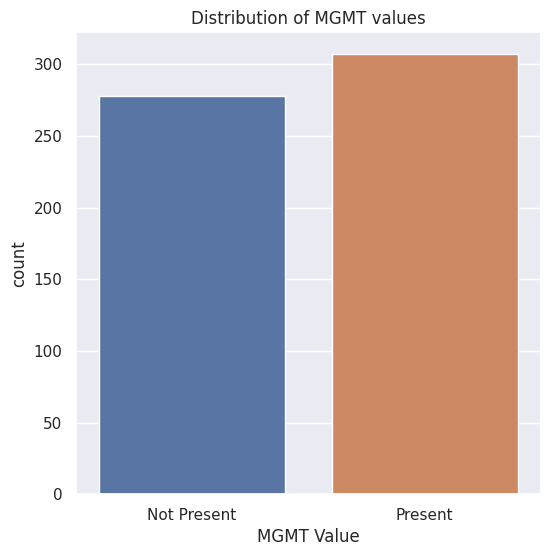

In [69]:
plt.figure(figsize=(6, 6))
sns.countplot(data=preview_dataset_df, x="MGMT_value")
plt.title("Distribution of MGMT values")
plt.xlabel("MGMT Value")
plt.xticks([0, 1], ["Not Present", "Present"])
plt.show()

The **"test/"** directory contains the test files. For each subject in the test data, there is no file containing the methylation targets, so these values must be predicted. The **"sample_submission.csv"** file is an example of a correctly formatted submission file, with MGMT values of **0.5** for each subject.

Overall, the task of the competition is to predict the presence of MGMT (%) promoter methylation for each subject in the test data.

In [70]:
samp_subm.head(1)

,BraTS21ID,MGMT_value
0,1,0.5


The dataset we will be working with consists of MRI data provided by the Radiological Society of North America (RSNA®) and the Medical Imaging Computation and Computer Assistance Society (MICCAI Society). 
The images are provided in DICOM format and are accompanied by a CSV file containing radiomic features extracted from the images.

In [71]:
first_folder = str(preview_dataset_df.loc[0, 'BraTS21ID']).zfill(5) + "/"
title = "Folders content for all patients"
# Folders content
folder_path = train_folder_path + first_folder  # Replace train_folder_path with the actual path
folder_content = os.listdir(folder_path)

df = pd.DataFrame({
        title: folder_content
    })
df.set_index(title, inplace=True)
df.head()

""
Folders content for all patients
T2w
T1wCE
T1w
FLAIR


In the first Dataset of the patient (ID: "00000") , we will explore the images contained in **['T2w', 'T1wCE', 'T1w', 'FLAIR']** of the first patient.

In [72]:
first_folder = str(preview_dataset_df.loc[0, 'BraTS21ID']).zfill(5) + "/"
folder_path = train_folder_path + first_folder  # Replace train_folder_path with the actual path

title = 'Image Type'
flair_count = len(os.listdir(folder_path + 'FLAIR'))
t1w_count = len(os.listdir(folder_path + 'T1w'))
t1wce_count = len(os.listdir(folder_path + 'T1wCE'))
t2w_count = len(os.listdir(folder_path + 'T2w'))

data = {
    title: ['FLAIR', 'T1w', 'T1wCE', 'T2w'],
    'Count': [flair_count, t1w_count, t1wce_count, t2w_count]
}


df = pd.DataFrame(data)
df.set_index(title, inplace=True)


df.head()

,Count
Image Type,
FLAIR,400
T1w,33
T1wCE,129
T2w,408


## <a id='exploratory_data_2_1'>2.1. MRI (FLAIR, T1w, T1wCE, T2w)</a>



The files are mpMRI scans, this includes:

- **Fluid Attenuated Inversion Recovery (FLAIR)**
    * **What it is:** These are images that detect brain abnormalities, such as edema and inflammatory lesions. These images are sensitive to the detection of anomalies related to inflammatory and infectious diseases of the central nervous system.
    * **What it highlights:** It helps to detect anomalies in the brain that might not be visible in other MRI sequences.
    * These images allow for the detection of brain abnormalities related to inflammatory and infectious diseases of the central nervous system.

In [ ]:
show_brain_slices(train_folder_path + "00000/FLAIR", split_by = 13)

- **T1-weighted pre-contrast (T1w)**
    * **What it is:** These are images that highlight soft tissues, such as muscles and nerves, and are useful for visualizing normal brain structures.
    * **What it highlights:** It allows the visualization of the normal brain structures and also helps in the detection of tumors and lesions.
    * These images allow for the detection of brain tumors and lesions.


In [ ]:
show_brain_slices(train_folder_path + "00000/T1w")

-  **T1-weighted post-contrast (T1wCE or T1Gd)**
    * **What it is:** These are images that use a contrast agent to detect vascular anomalies, such as tumors and lesions, which are more visible after contrast agent administration.
    * **What it highlights:** It enhances the visibility of vascular anomalies, such as tumors and lesions, making it easier to detect them.
    * These images allow for the detection of vascular anomalies, such as tumors and lesions.


In [ ]:
show_brain_slices(train_folder_path + "00000/T1wCE", split_by = 4)

- **T2-weighted (T2w or T2)**
    * **What it is:** These images detect abnormalities related to demyelination, such as multiple sclerosis, as well as brain tumors and lesions.
    * **What it highlights:** It helps in the detection of anomalies related to cerebrospinal fluid, such as cysts and brain tumors.
    * These images allow for the detection of anomalies related to demyelination, brain tumors, lesions, and cerebrospinal fluid.

In [ ]:
show_brain_slices(train_folder_path + "00000/T2w", split_by = 13)

MRI sequences: **FLAIR, T1wCE, T1w, T2w**

In [ ]:
image_path = "https://github.com/YanSteph/RSNA-MICCAI-Brain-Tumor-Classification-AI/blob/main/img/scan1.png?raw=true"
html_code = f'<img src="{image_path}" style="width: 700px;" />'
display(HTML(html_code))

## <a id='exploratory_data_2_1'>2.2. Highlight features or areas of interest MRI</a>

The "Hot" palette palette with Red and Yellow is commonly used in medicine to highlight areas of high activity or high intensity in brain images.

This palette uses warm colors, ranging from black to bright red, to visually represent regions of intense brain activity or high intensity values. These warm colors help highlight areas of interest and clearly distinguish them from areas of low activity or intensity.

In medicine, this can be particularly useful for visualizing aspects such as neuronal activity, areas of blood flow concentration, the intensity of certain characteristics or measurements, or any other relevant information related to activity or intensity in the brain.

Using the "Hot" palette makes it easier to quickly identify regions of high activity or intensity, which can be critical for healthcare professionals in interpreting brain images and detecting features or areas of interest.

## <a id='exploratory_data_2_2'>2.3. Exploratory quality and interpretation of the MRI</a>


Here is the list of examples of arguments supporting that an MRI is well performed and that the scans are appropriate for the study:

1. **Image resolution and quality:** A well-executed MRI will produce high-resolution images with clear image quality. This enables healthcare professionals to observe anatomical structures accurately and detect any potential abnormalities.

2.  **Proper contrast:** The use of contrast agents during an MRI can enhance the visualization of certain structures or pathologies. When a scan is correctly performed, contrast will be applied appropriately, facilitating the identification of areas of interest.

3.  **Positioning and immobilization:** High-quality MRI requires precise patient positioning and good immobilization to prevent unwanted movements during the procedure. When the patient is properly positioned and kept still, the obtained images will be more reliable and interpretable.

4.  **Appropriate acquisition protocol:** Each type of MRI requires a specific acquisition protocol based on the body part being studied and the purpose of the examination. When the protocol is followed correctly, the images will provide the necessary information for diagnosis or study.

5.  **Accurate interpretation:** Lastly, for an MRI to be well-executed and the scans ready for study, it is essential that interpretation is carried out by a qualified professional, such as a radiologist. Accurate interpretation of the images allows for the identification of potential abnormalities, proper diagnosis, and the recommendation of necessary treatments.

It is important to note that these arguments are general and that there are many more.

In [ ]:
number_of_extraction = 3


# Filtre df mght 1 and 0
patient_without_mgmt = preview_dataset_df.loc[preview_dataset_df["MGMT_value"] == 0].sort_values('BraTS21ID')
patient_with_mgmt = preview_dataset_df.loc[preview_dataset_df["MGMT_value"] == 1].sort_values('BraTS21ID')

# Collonne selected
patient_with_mgmt_folder_ids = patient_with_mgmt[["BraTS21ID", "MGMT_value"]].iloc[:number_of_extraction]
patient_without_mgmt_folder_ids = patient_without_mgmt[["BraTS21ID", "MGMT_value"]].iloc[:number_of_extraction]

# map df into tupple
patient_with_mgmt_mapped_tuples = map_dataframe_to_tuples(patient_with_mgmt_folder_ids, ["BraTS21ID", "MGMT_value"])
patient_without_mgmt_mapped_tuples = map_dataframe_to_tuples(patient_without_mgmt_folder_ids, ["BraTS21ID", "MGMT_value"])

# Merge
patient_combined_with_and_without_mgmt_ids = list(chain.from_iterable(zip(patient_with_mgmt_mapped_tuples, patient_without_mgmt_mapped_tuples)))

# Show
show_brains(patient_combined_with_and_without_mgmt_ids, figsize = (8, 5), dataset_version = dataset_version)

When an MRI is performed improperly or the scan is of poor quality, several issues can arise, potentially leading to adverse consequences for the patient. 

Here potential problems:

1.  **Image artifacts:** A poorly performed MRI can result in artifacts, which are distortions or errors in the image. This can make interpretation difficult or even impossible, leading to incorrect or incomplete diagnoses.

2.  **Insufficient image quality:** Improper execution of the MRI can lead to insufficient image quality. Inadequate resolution or excessive blurring can make it difficult to accurately identify anatomical structures or lesions, compromising the reliability of the diagnosis.

3.  **Positioning errors:** Proper patient positioning is crucial during an MRI to obtain precise and consistent images. Incorrect positioning, such as poor immobilization or improper device calibration, can cause deformations and significant loss of information.

4.  **Motion artifacts:** MRI often requires the patient to remain still during image acquisition. Any involuntary movement, such as tremors or respiratory motion, can introduce motion artifacts into the image. These artifacts can mask abnormalities or lead to incorrect interpretation of the results.

5.  **Parameter setting errors:** The parameters used in an MRI, such as the acquisition sequence, echo time, or repetition time, need to be properly defined based on the clinical objective. Parameter setting errors can result in poor visualization of certain structures or inappropriate sensitivity to detect certain pathologies.

6.  **Region of interest not covered:** When an MRI is poorly positioned or planning errors occur, it is possible that the region of interest may not be fully covered by the image. This can lead to a loss of essential information and incomplete evaluation of the area under examination, thereby compromising the accuracy of the diagnosis.


These are just an example. It is important to note that these problems are not exclusive to a single MRI scan. They can occur in exceptional circumstances or due to human error.

Here a preview of wrong IRM:

In [ ]:
excluded_patient_ids = [109, 123, 709] 

patient_with_wrong_mri_ids = preview_dataset_df.loc[(preview_dataset_df["BraTS21ID"].isin(excluded_patient_ids))].sort_values('BraTS21ID')
patient_with_wrong_mri_ids_tuples = map_dataframe_to_tuples(patient_with_wrong_mri_ids, ["BraTS21ID", "MGMT_value"])

show_brains(patient_with_wrong_mri_ids_tuples, figsize = (8, 5), dataset_version = dataset_version)

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>📝 Note:</strong></h2>
        <ul>
            <li>Our training dataset consists of <b>585 patients</b>, which is relatively limited for machine learning. A larger dataset would provide more robust results.</li>
            <li>Submissions are evaluated on the area under the <b>ROC curve</b> between the predicted probability and the observed target. <a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic" style="color: white;">🔗 Link: ROC (Receiver operating characteristic)</a>.</li>
            <li>For the submission file each BraTS21ID in the test set, we must predict a <b>probability (%)</b> for the <b>target MGMT_value.</b></li>
            <li>We need to split the given <b>train sets into two parts: one for train and the other for test.</b></li>
            <li>Report on the competition page, there are unexpected issues with the following cases in the training dataset, <b>we will exclude these patient IDs:</b>
                <ul>
                    <li><b>[109, 123, 709]</b></li>
                </ul>
            </li>
            <li>To ensure accurate prediction results, <b>we exclude the "/test" folder</b>, it only contains thresholded values of <b>0.5</b> and this is the part of submission to the competition.</li>
        </ul>
    </div>
</div>
</br>
<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>🛠 Global:</strong></h2>
        <ul>
            <li>Excluded patient IDs: <b>`excluded_patient_ids`</b></li>
            <li>We excluded this patient Ids for the rest of the project.</li>
                <ul>
                    <li><b>[109, 123, 709]</b></li>
                </ul>
        </ul>
    </div>
</div>

----

# <a id='brain_segmentation'>3. Brain segmentation</a>
The "mateuszbuda_brain-segmentation-pytorch_unet" library was chosen to facilitate brain segmentation from medical images in our project. This section outlines the reasons behind selecting this library and its contribution to achieving accurate brain segmentation results.

Source: [mateuszbuda_brain-segmentation-pytorch_unet on PyTorch Hub](https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/)

## <a id='brain_segmentation_3_1'>3.1. Importance of Brain Segmentation</a>
Brain segmentation is a crucial task in medical imaging as it enables the extraction of precise information about different regions or classes within the brain structures. Accurate segmentation plays a vital role in various medical applications, including tumor detection, anatomical analysis, and treatment planning.

## <a id='brain_segmentation_3_2'>3.2. Selection Criteria</a>
The "mateuszbuda_brain-segmentation-pytorch_unet" library was chosen based on the following criteria:

* **Exceptional Performance:** The library has demonstrated exceptional performance in brain segmentation tasks, providing accurate and reliable results.
Unet Architecture: It is specifically designed based on the Unet neural network architecture, which has a proven track record of success in biomedical image segmentation.
* **User-Friendly Nature:** The library offers a user-friendly interface and efficient implementation, allowing researchers and practitioners to easily integrate it into their projects.

## <a id='brain_segmentation_3_3'>3.3. Contributions of the Library</a>
The utilization of the "mateuszbuda_brain-segmentation-pytorch_unet" library significantly contributed to the acquisition of accurate brain segmentation data for our dataset. By leveraging the library's capabilities, we were able to efficiently segment medical images and extract valuable information for further analysis and research purposes.

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>📝 Note:</strong></h2>
        <p style="color: white;">👉🏿 In summary, the selection of the <b>"mateuszbuda_brain-segmentation-pytorch_unet"</b> library was based on its exceptional performance, user-friendly nature, and utilization of the powerful Unet architecture. This library played a pivotal role in achieving accurate brain segmentation results and provided a solid foundation for our project's objectives.</p>
    </div>
</div>


   
# <a id='utilizing_unet_4'>4. Utilizing the U-Net for Brain MRI Model and RadiomicsShape3D Class</a>
In order to leverage 3D capabilities for brain segmentation, we will utilize the U-Net for Brain MRI model and the RadiomicsShape3D class. This section provides an overview of the model's architecture and the usage instructions for performing 3D brain segmentation and shape analysis.

## <a id='utilizing_unet_4_1'>4.1. Architecture</a>
The U-Net for Brain MRI model in 3D extends the 2D architecture to process volumetric brain images. It follows a similar U-shaped architecture with skip connections, but the convolutional layers operate in a 3D manner. The model consists of encoder and decoder paths, with each path containing multiple levels of blocks. The number of filters in the convolutional layers varies across the levels, allowing the model to capture different levels of details in the volumetric data.

## <a id='utilizing_unet_4_2'>4.2. Usage Instructions</a>
To utilize the 3D U-Net for Brain MRI model, follow these steps:

Prepare a brain MRI volume with three channels corresponding to pre-contrast, FLAIR, and post-contrast sequences.
Preprocess the volume by resizing it to an appropriate spatial resolution and normalizing the intensity values.
Feed the preprocessed volume to the U-Net model for segmentation. The model will output a probability map representing the likelihood of abnormal regions in the input volume.
Apply a suitable threshold to the probability map to obtain a binary segmentation mask.

## <a id='utilizing_unet_4_3'>4.3. RadiomicsShape3D Class</a>
To perform shape analysis on the segmented brain regions, we will utilize the "radiomics.shape3D.RadiomicsShape3D" class. This class provides functionalities for analyzing the 3D shape characteristics of segmented regions in medical images.

## <a id='utilizing_unet_4_4'>4.4. Usage Instructions</a>
To utilize the RadiomicsShape3D class, follow these steps:

Obtain the segmented regions or masks from the 3D U-Net model.
Instantiate the RadiomicsShape3D class.

Source: [Radiomics 3D](https://pyradiomics.readthedocs.io/en/latest/features.html#module-radiomics.shape3D)

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>📝 Note:</strong></h2>
        <ul>
            <li>By incorporating the 3D U-Net for Brain MRI model and the RadiomicsShape3D class, we have extended the capabilities of our project to volumetric brain image analysis. This allows for more comprehensive segmentation and shape analysis, facilitating advanced medical research and clinical applications.</li>
            <li>Initially, we worked with 2D data, where we only considered the central slice of the images. However, given the size of our dataset and the limitation of 2D visualization in providing a complete understanding of the brain structure, it seemed appropriate to transition to a 3D approach. By working with 3D image volumes, we were able to increase the richness of our data and obtain a more comprehensive representation of the brain's features. This transition to 3D offers new perspectives for more detailed analysis and more accurate results.</li>
        </ul>
    </div>
    <p style="color: white;">👉🏿 Thus, by leveraging the 3D U-Net model and the RadiomicsShape3D class, we are able to fully harness the benefits offered by volumetric image analysis.</p>
</div>


# <a id='dataset_creation_5'>5. Dataset Preparation</a>

In order to proceed, we need to partition the given training dataset into two sets: training and testing. 

However, it is important to note that there are certain issues with three specific cases in the training dataset, namely [00109, 00123, 00709], as reported on the main contest page. 

Therefore, we will exclude these cases from the dataset.

In [ ]:
if skip_brain_segmentation_pytorch_unet:
    dataset_df = pd.read_csv(dataset_3d_path if dataset_version == DatasetVersion.V_3D else dataset_2d_path)
    
else:
    loader = widgets.IntProgress(min=0, max=len(preview_dataset_df), description='Loading:')
    display(loader)
    
    # Empty creation of datasets
    init_dataset_radiomics()

    for i in preview_dataset_df.BraTS21ID :
        loader.value += 1
        img_resized = get_processed_image(i, dataset_version)
        segmentation = segmentation_process(img_resized)

        if dataset_version == DatasetVersion.V_3D:
            add_patient_data3D(i, img_resized, segmentation)
        else : 
            add_patient_data2D(i, img_resized, segmentation)

    # Join the 7 datasets
    df_shapes = df_shapes.set_index('ID')
    df_textures = df_textures.set_index('ID')
    df_first_orders_features = df_first_orders_features.set_index('ID')

    df_gzlm_features = df_gzlm_features.set_index('ID').add_prefix('gzlm_')
    df_glrlm_features = df_glrlm_features.set_index('ID').add_prefix('glrlm_')
    df = df_shapes.join(df_textures).join(df_first_orders_features)
    df_ngtdm_features = df_ngtdm_features.set_index('ID').add_prefix('ngtdm_')
    df_gldm_features = df_gldm_features.set_index('ID').add_prefix('gldm_')
    
    df = df_shapes.join(df_textures).join(df_first_orders_features).join(df_gzlm_features).join(df_glrlm_features).join(df_ngtdm_features).join(df_gldm_features)

    # Define 'BraTS21ID' column as integer IDs
    df['BraTS21ID'] = df['BraTS21ID'].astype(int)
    
    # Merge the old dataset with the new one
    dataset_df = pd.merge(preview_dataset_df, df, left_on='BraTS21ID', right_on='BraTS21ID')
    dataset_df.rename(columns={'BraTS21ID': 'ID'}, inplace=True)

# Patient BraTS21ID now is ID, and ID of Dataset
dataset_df = dataset_df.set_index('ID')
# Drop patient
dataset_df = dataset_df.drop(index=excluded_patient_ids)

show_download_link(dataset_df)

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>🛠 Global:</strong></h2>
        <ul>
            <li>Segmentation Dataset 2D or 3D: <b>`dataset_df`</b></li> 
            <li>We excluded patient Ids with wrong data for the rest of the project.</li>
        </ul>
    </div>
</div>

<hr>

# <a id='exploratory_dataset'>6. Exploratory Dataset</a>

These features provide information about various properties of brain MRI images, such as shape, texture, and grayscale statistics. They are commonly used for analysis and classification of medical images to aid in the detection and characterization of brain pathologies.

Here is the requested list of features extracted from brain MRI images:

<details>
  <summary style="font-weight: bold; font-size: 1.2em;">▶️ General Features:</summary>
  <ul>
    <li><strong>ID:</strong> Sample identifier (Index).</li>
    <li><strong>MGMT_value:</strong> Presence of MGMT.</li>
  </ul>
</details>

<details>
  <summary style="font-weight: bold; font-size: 1.2em;"><strong>▶️ First Order Statistics Features:</strong></summary>
  <ul>
    <li><strong>10Percentile:</strong> The 10th percentile of the image array.</li>
    <li><strong>90Percentile:</strong> The 90th percentile of the image array.</li>
    <li><strong>Energy:</strong> A measure of the magnitude of voxel values in an image. A larger value implies a greater sum of the squares of these values.</li>
    <li><strong>Entropy:</strong> Specifies the uncertainty/randomness in the image values. It measures the average amount of information required to encode the image values.</li>
    <li><strong>InterquartileRange:</strong> The difference between the 75th and 25th percentile of the image array.</li>
    <li><strong>Kurtosis:</strong> A measure of the ‘peakedness’ of the distribution of values in the image ROI. A higher kurtosis implies that the mass of the distribution is concentrated towards the tail(s) rather than towards the mean. A lower kurtosis implies the reverse: that the mass of the distribution is concentrated towards a spike near the Mean value.</li>
    <li><strong>Maximum:</strong> The maximum gray level intensity within the ROI.</li>
    <li><strong>MeanAbsoluteDeviation:</strong> The mean distance of all intensity values from the Mean Value of the image array.</li>
    <li><strong>Mean:</strong> The average gray level intensity within the ROI.</li>
    <li><strong>Median:</strong> The median gray level intensity within the ROI.</li>
    <li><strong>Minimum:</strong> The minimum gray level intensity within the ROI.</li>
    <li><strong>Range:</strong> The range of gray values in the ROI.</li>
    <li><strong>RobustMeanAbsoluteDeviation:</strong> The mean distance of all intensity values from the Mean Value calculated on the subset of image array with gray levels in between, or equal to the 10th and 90th percentile.</li>
    <li><strong>RootMeanSquared:</strong> The square-root of the mean of all the squared intensity values. It is another measure of the magnitude of the image values.</li>
    <li><strong>Skewness:</strong> Measures the asymmetry of the distribution of values about the Mean value. Depending on where the tail is elongated and the mass of the distribution is concentrated, this value can be positive or negative.</li>
    <li><strong>TotalEnergy:</strong> The value of Energy feature scaled by the volume of the voxel in cubic mm.</li>
    <li><strong>Uniformity:</strong> A measure of the sum of the squares of each intensity value. This is a measure of the homogeneity of the image array, where a greater uniformity implies a greater homogeneity or a smaller range of discrete intensity values.</li>
    <li><strong>Variance:</strong> The mean of the squared distances of each intensity value from the Mean value. This is a measure of the spread of the distribution about the mean.</li>
  </ul>
</details>

<details>
  <summary style="font-weight: bold; font-size: 1.2em;"><strong>▶️ Shape (3D) Features:</strong></summary>
  <ul>
    <li><strong>MeshVolume:</strong> The volume of the ROI is calculated from the triangle mesh of the ROI. For each face in the mesh, the (signed) volume of the tetrahedron defined by that face and the origin of the image is calculated. The total volume of the ROI is obtained by taking the sum of all these volumes.</li>
    <li><strong>VoxelVolume:</strong> The volume of the ROI is approximated by multiplying the number of voxels in the ROI by the volume of a single voxel. This is a less precise approximation of the volume and is not used in subsequent features.</li>
    <li><strong>SurfaceArea:</strong> To calculate the surface area, first the surface area of each triangle in the mesh is calculated. The total surface area is then obtained by taking the sum of all calculated sub-areas.</li>
    <li><strong>SurfaceVolumeRatio:</strong> This is the ratio of the surface area of the tumor region to the volume of the tumor region. A lower value indicates a more compact (sphere-like) shape.</li>
    <li><strong>Sphericity:</strong> Sphericity is a measure of the roundness of the shape of the tumor region relative to a sphere. It is a dimensionless measure, independent of scale and orientation.</li>
    <li><strong>Compactness1:</strong> Similar to Sphericity, Compactness 1 is a measure of how compact the shape of the tumor is relative to a sphere (most compact).</li>
    <li><strong>Compactness2:</strong> Similar to Sphericity and Compactness 1, Compactness 2 is a measure of how compact the shape of the tumor is relative to a sphere (most compact).</li>
    <li><strong>SphericalDisproportion:</strong> Spherical Disproportion is the ratio of the surface area of the tumor region to the surface area of a sphere with the same volume as the tumor region, and by definition, the inverse of Sphericity.</li>
    <li><strong>Maximum3DDiameter:</strong> Maximum 3D diameter is defined as the largest pairwise Euclidean distance between tumor surface mesh vertices.</li>
    <li><strong>Maximum2DDiameterSlice:</strong> Maximum 2D diameter (Slice) is defined as the largest pairwise Euclidean distance between tumor surface mesh vertices in the row-column (generally the axial) plane.</li>
    <li><strong>Maximum2DDiameterColumn:</strong> Maximum 2D diameter (Column) is defined as the largest pairwise Euclidean distance between tumor surface mesh vertices in the row-slice (usually the coronal) plane.</li>
    <li><strong>Maximum2DDiameterRow:</strong> Maximum 2D diameter (Row) is defined as the largest pairwise Euclidean distance between tumor surface mesh vertices in the column-slice (usually the sagittal) plane.</li>
    <li><strong>MajorAxisLength:</strong> This feature yields the largest axis length of the ROI-enclosing ellipsoid and is calculated using the largest principal component.</li>
    <li><strong>MinorAxisLength:</strong> This feature yields the second-largest axis length of the ROI-enclosing ellipsoid and is calculated using the second largest principal component.</li>
    <li><strong>LeastAxisLength:</strong> This feature yields the smallest axis length of the ROI-enclosing ellipsoid and is calculated using the smallest principal component.</li>
    <li><strong>Elongation:</strong> Elongation shows the relationship between the two largest principal components in the ROI shape.</li>
    <li><strong>Flatness:</strong> Flatness shows the relationship between the largest and smallest principal components in the ROI shape.</li>
    <li><strong>MinorAxisLength:</strong> Not found.</li>
  </ul>
</details>

<details>
  <summary style="font-weight: bold; font-size: 1.2em;"><strong>▶️ Gray Level Co-occurrence Matrix (GLCM) Features:</strong></summary>
  <ul>
    <li><strong>Autocorrelation</strong>: This is a measure of the magnitude of the fineness and coarseness of texture.</li>
    <li><strong>ClusterProminence</strong>: A measure of the asymmetry and complexity of the texture.</li>
    <li><strong>ClusterShade</strong>: A measure of skewness and uniformity of the texture.</li>
    <li><strong>ClusterTendency</strong>: A measure of groupings of voxels with similar gray-level values.</li>
    <li><strong>Contrast</strong>: A measure of the local variations in the gray-level co-occurrence matrix.</li>
    <li><strong>Correlation</strong>: A measure of the joint probability occurrence of the specified pixel pairs.</li>
    <li><strong>DifferenceAverage</strong>: Provides a measure of contrast in an image.</li>
    <li><strong>DifferenceEntropy</strong>: A measure of randomness or variation in an image.</li>
    <li><strong>DifferenceVariance</strong>: A measure of heterogeneity that places higher weights on differing intensity level pairs.</li>
    <li><strong>Id</strong>: Inverse Difference (ID) is a measure of local homogeneity.</li>
    <li><strong>Idm</strong>: Inverse Difference Moment (IDM) is another measure of local homogeneity.</li>
    <li><strong>Idmn</strong>: Inverse Difference Moment Normalized (IDMN) is a measure of local homogeneity with a higher emphasis on smaller gray-level differences.</li>
    <li><strong>Idn</strong>: Inverse Difference Normalized (IDN) is a measure of local homogeneity with a higher emphasis on larger gray-level differences.</li>
    <li><strong>Imc1</strong>: Informational Measure of Correlation 1 (IMC1) is a measure of complexity.</li>
    <li><strong>Imc2</strong>: Informational Measure of Correlation 2 (IMC2) is another measure of complexity.</li>
    <li><strong>InverseVariance</strong>: A measure of the sum of squares of each intensity value.</li>
    <li><strong>JointAverage</strong>: The average value of the joint histogram of the image.</li>
    <li><strong>JointEnergy</strong>: A measure of similarity of the distribution of the joint histogram to that of the image.</li>
    <li><strong>JointEntropy</strong>: A measure of uncertainty or randomness.</li>
    <li><strong>MCC</strong>: Maximal Correlation Coefficient (MCC) is a measure of correlation between elements in the GLCM.</li>
    <li><strong>MaximumProbability</strong>: The maximum probability value in the GLCM.</li>
    <li><strong>SumAverage</strong>: The average sum of gray-level pairs in the GLCM.</li>
    <li><strong>SumEntropy</strong>: A measure of randomness or complexity in the GLCM.</li>
    <li><strong>SumSquares</strong>: A measure of the variance in the GLCM.</li>
  </ul>
</details>

<details>
  <summary style="font-weight: bold; font-size: 1.2em;"><strong>▶️ Gray Level Size Zone Matrix (GLSZM) Features:</strong></summary>
  <ul>
    <li><strong>SmallAreaEmphasis:</strong> Measures the proportion of small size zones, with a higher value indicating a greater proportion of small size zones.</li>
    <li><strong>LargeAreaEmphasis:</strong> Measures the proportion of large size zones, with a higher value indicating a greater proportion of large size zones.</li>
    <li><strong>GrayLevelNonUniformity:</strong> Measures the similarity of gray-level intensity values in the image, with a lower value indicating a greater similarity in intensity values.</li>
    <li><strong>GrayLevelNonUniformityNormalized:</strong> Measures the similarity of gray-level intensity values in the image, with a lower value indicating a greater similarity in intensity values. This is normalized to account for differences in the size of the region of interest.</li>
    <li><strong>SizeZoneNonUniformity:</strong> Measures the variability of size-zone lengths throughout the image, with a lower value indicating more homogeneity in size-zone lengths.</li>
    <li><strong>SizeZoneNonUniformityNormalized:</strong> Measures the variability of size-zone lengths throughout the image, with a lower value indicating more homogeneity in size-zone lengths. This is normalized to account for differences in the size of the region of interest.</li>
    <li><strong>ZonePercentage:</strong> Measures the number of size-zones per number of voxels in the region of interest.</li>
    <li><strong>GrayLevelVariance:</strong> Measures the variance in gray-level intensity values.</li>
    <li><strong>ZoneVariance:</strong> Measures the variance of size-zone lengths.</li>
    <li><strong>ZoneEntropy:</strong> Measures the uncertainty/randomness of the size-zone length distribution.</li>
    <li><strong>LowGrayLevelZoneEmphasis:</strong> Measures the proportion of low gray-level size zones.</li>
    <li><strong>HighGrayLevelZoneEmphasis:</strong> Measures the proportion of high gray-level size zones.</li>
    <li><strong>SmallAreaLowGrayLevelEmphasis:</strong> Measures the proportion of small size zones with lower gray-level values.</li>
    <li><strong>SmallAreaHighGrayLevelEmphasis:</strong> Measures the proportion of small size zones with higher gray-level values.</li>
    <li><strong>LargeAreaLowGrayLevelEmphasis:</strong> Measures the proportion of larger size zones with lower gray-level values.</li>
    <li><strong>LargeAreaHighGrayLevelEmphasis:</strong> Measures the proportion of larger size zones with higher gray-level values.</li>
  </ul>
</details>

<details>
  <summary style="font-weight: bold; font-size: 1.2em;"><strong>▶️ Gray Level Run Length Matrix (GLRLM) Features:</strong></summary>
  <ul>
    <li><strong>ShortRunEmphasis:</strong> Measures the distribution of short runs, with a lower value indicating a greater prevalence of longer runs.</li>
    <li><strong>LongRunEmphasis:</strong> Measures the distribution of long runs, with a higher value indicating a greater prevalence of longer runs.</li>
    <li><strong>GrayLevelNonUniformity:</strong> Measures the similarity of run lengths throughout the image, with a lower value indicating a greater similarity in run lengths.</li>
    <li><strong>RunLengthNonUniformity:</strong> Measures the similarity of gray-level intensity values in the image, with a lower value indicating more homogeneity.</li>
    <li><strong>RunLengthNonUniformityNormalized:</strong> This is the normalized version of the Run Length Non-Uniformity feature.</li>
    <li><strong>RunPercentage:</strong> This is a measure of the coarseness of the texture, with a higher value indicating a coarser texture.</li>
    <li><strong>GrayLevelVariance:</strong> Measures the variance in gray-level intensity values in the image.</li>
    <li><strong>RunVariance:</strong> Measures the variance of runs lengths in the image.</li>
    <li><strong>RunEntropy:</strong> A measure of complexity or information that can be extracted from the GLRLM matrix.</li>
    <li><strong>LowGrayLevelRunEmphasis:</strong> Measures the proportion of runs with lower gray-level values.</li>
    <li><strong>HighGrayLevelRunEmphasis:</strong> Measures the proportion of runs with higher gray-level values.</li>
    <li><strong>ShortRunLowGrayLevelEmphasis:</strong> Measures the joint distribution of shorter run lengths and lower gray-level values.</li>
    <li><strong>ShortRunHighGrayLevelEmphasis:</strong> Measures the joint distribution of shorter run lengths and higher gray-level values.</li>
    <li><strong>LongRunLowGrayLevelEmphasis:</strong> Measures the joint distribution of longer run lengths and lower gray-level values.</li>
    <li><strong>LongRunHighGrayLevelEmphasis:</strong> Measures the joint distribution of longer run lengths and higher gray-level values.</li>
    <li><strong>RunPercentage:</strong> The Run Percentage measures the proportion of runs in the image that have a length longer than the specified run length. It quantifies the coarseness or texture of the image, with a higher value indicating a coarser texture.</li>
  </ul>
</details>

<details>
  <summary style="font-weight: bold; font-size: 1.2em;"><strong>▶️ Gray Level Dependence Matrix (GLDM) Features:</strong></summary>
  <ul>
    <li><strong>SmallDependenceEmphasis (SDE):</strong> Measures the distribution of small dependencies with lower values indicating a greater proportion of small dependencies in the image. Small dependencies are considered those that are shorter than the specified dependence length.</li>
    <li><strong>LargeDependenceEmphasis (LDE):</strong> Measures the distribution of large dependencies with higher values indicating a greater proportion of large dependencies in the image. Large dependencies are considered those that are longer than the specified dependence length.</li>
    <li><strong>GrayLevelNonUniformity (GLN):</strong> Measures the similarity of gray-level intensity values in the image, with a lower value indicating a greater similarity in intensity values.</li>
    <li><strong>GrayLevelNonUniformityNormalized (GLNN):</strong> Measures the similarity of gray-level intensity values in the image, with a lower value indicating a greater similarity in intensity values. This is a normalized version of the Gray Level Non-Uniformity feature.</li>
    <li><strong>DependenceNonUniformity (DN):</strong> Measures the similarity of dependencies in the image, with a lower value indicating a greater similarity in dependencies.</li>
    <li><strong>DependenceNonUniformityNormalized (DNN):</strong> Measures the similarity of dependencies in the image, with a lower value indicating a greater similarity in dependencies. This is a normalized version of the Dependence Non-Uniformity feature.</li>
    <li><strong>GrayLevelVariance (GLV):</strong> Measures the variance in gray-level intensity values.</li>
    <li><strong>DependenceVariance (DV):</strong> Measures the variance of dependencies in the image.</li>
    <li><strong>DependenceEntropy (DE):</strong> Measures the uncertainty/randomness of the distribution of dependencies in the image. It measures the average amount of information required to encode the dependencies.</li>
    <li><strong>DependencePercentage (DP):</strong> Measures the percentage of dependencies in the image that are longer than the specified dependence length.</li>
    <li><strong>LowGrayLevelEmphasis (LGLE):</strong> Measures the proportion of low gray-level intensity values.</li>
    <li><strong>HighGrayLevelEmphasis (HGLE):</strong> Measures the proportion of high gray-level intensity values.</li>
    <li><strong>SmallDependenceLowGrayLevelEmphasis (SDLGLE):</strong> Measures the joint distribution of small dependencies and low gray-level values.</li>
    <li><strong>SmallDependenceHighGrayLevelEmphasis (SDHGLE):</strong> Measures the joint distribution of small dependencies and high gray-level values.</li>
    <li><strong>LargeDependenceLowGrayLevelEmphasis (LDLGLE):</strong> Measures the joint distribution of large dependencies and low gray-level values.</li>
    <li><strong>LargeDependenceHighGrayLevelEmphasis (LDHGLE):</strong> Measures the joint distribution of large dependencies and high gray-level values.</li>
    <li><strong>DependenceNonUniformity (DN):</strong> Measures the similarity of dependencies in the image, with a lower value indicating a greater similarity in dependencies.</li>
    <li><strong>DependenceNonUniformityNormalized (DNN):</strong> Measures the similarity of dependencies in the image, with a lower value indicating a greater similarity in dependencies. This is a normalized version of the Dependence Non-Uniformity feature.</li>
    <li><strong>DependenceVariance (DV):</strong> Measures the variance of dependencies in the image.</li>
    <li><strong>DependenceEntropy (DE):</strong> Measures the uncertainty/randomness of the distribution of dependencies in the image. It measures the average amount of information required to encode the dependencies.</li>
    <li><strong>DependencePercentage (DP):</strong> Measures the percentage of dependencies in the image that are longer than the specified dependence length.</li>
    <li><strong>SmallDependenceLowGrayLevelEmphasis (SDLGLE):</strong> Measures the joint distribution of small dependencies and low gray-level values.</li>
    <li><strong>SmallDependenceHighGrayLevelEmphasis (SDHGLE):</strong> Measures the joint distribution of small dependencies and high gray-level values.</li>
    <li><strong>LargeDependenceLowGrayLevelEmphasis (LDLGLE):</strong> Measures the joint distribution of large dependencies and low gray-level values.</li>
    <li><strong>LargeDependenceHighGrayLevelEmphasis (LDHGLE):</strong> Measures the joint distribution of large dependencies and high gray-level values.</li>
    <li><strong>DependenceNonUniformity (DN):</strong> Measures the similarity of dependencies in the image, with a lower value indicating a greater similarity in dependencies. It quantifies the variation in the distribution of dependencies.</li>
    <li><strong>DependenceNonUniformityNormalized (DNN):</strong> Measures the similarity of dependencies in the image, with a lower value indicating a greater similarity in dependencies. This is a normalized version of the Dependence Non-Uniformity feature that accounts for differences in the size of the region of interest.</li>
    <li><strong>DependencePercentage (DP):</strong> Measures the percentage of dependencies in the image that are longer than the specified dependence length. It quantifies the proportion of dependencies in the image.</li>
  </ul>
</details>



In [ ]:
dataset_df.head()

In [ ]:
dataset_df.info()

In [ ]:
dataset_df.describe()

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
   <div class="card-body">
      <h2 class="card-title" style="color: white;"><strong>📝 Note:</strong></h2>
      <p style="color: white;">Based on the provided analysis, we can draw the following conclusions:</p>
      <ul>
         <li>
            <strong>Distribution & Outliers:</strong>
            <ul>
               <li>Most have means that are significantly higher than the median, suggesting positive skew. Variables like <strong>'LeastAxisLength', 'Flatness', 'TotalEnergy', 'Maximum3DDiameter', 'Energy', 'Variance'</strong>, etc.</li>
               <li>The variables have positive skewness with large values. This can complicate data analysis.</li>
               <li>See also in the previous summary, have some wrong data to remove.</li>
               <ul>
                   <li>Apply feature scaling techniques to address the wide range of values and improve machine learning algorithm performance.</li>
               </ul>
            </ul>
         </li>
         <li>
            <strong>Zero Values:</strong>
            <ul>
               <li>Variables such as <strong>"LeastAxisLength", "Flatness", "gldm_GrayLevelNonUniformityNormalized", "gldm_DependencePercentage"</strong> show a minimum value of 0 or NaN, which might indicate missing or incorrect data.</li>
               <ul>
                   <li>We now remove these variables for the rest of the project.</li>
               </ul>
            </ul>
         </li>
         <li>
            <strong>Absence of Negative Values:</strong>
            <ul>
               <li>Most variables do not contain negative values, which makes sense considering they seem to represent physical measurements. (Brain MRI).</li>
            </ul>
         </li>
         <li>
            <strong>Potential Redundancy:</strong>
            <ul>
               <li>The <strong>'Id'</strong>, <strong>'Idm'</strong>, <strong>'Idmn'</strong>, and <strong>'Idn'</strong>, etc., variables appear to be very similar in terms of their statistical properties, which might indicate redundancy.</li>
               <ul>
                   <li>Potential redundancy, so high correlation. Potential variables to remove.</li>
               </ul>
            </ul>
         </li>
         <li>
            <strong>Data Correlations:</strong>
            <ul>
               <li>This basic statistical summary doesn't provide any information about possible correlations between <strong>'MeshVolume'</strong>, <strong>'VoxelVolume'</strong>, and <strong>'MGMT_value'</strong>.</li>
               <ul>
                   <li>The brain size does not affect MGMT values.</li>
               </ul>
            </ul>
         </li>
         <li>
            <strong>Statistical Variables:</strong>
            <ul>
               <li>The statistical variables included in the table, such as <strong>'Mean'</strong>, <strong>'Median'</strong>, <strong>'Maximum'</strong>, etc., are derived summaries or calculations based on other variables.</li>
               <ul>
                   <li>Potential for analysis and perhaps potential exclusion.</li>
               </ul>
            </ul>
         </li>
      </ul>
      <p style="color: white;">👉🏿 It's important to keep in mind that potential errors, biases, or other anomalies in how the data was gathered could influence these statistical properties.</p>
   </div>
</div>

In [ ]:
# First Orders features
first_orders_features_columns_names =['10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis', 
                                      'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median', 'Minimum', 'Range', 'RobustMeanAbsoluteDeviation', 
                                      'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Uniformity', 'Variance']

# Shape 3D  
shapes_features_columns_names = ['MeshVolume','VoxelVolume','SurfaceArea','SurfaceVolumeRatio','Sphericity',
                             'Compactness1','Compactness2','SphericalDisproportion','Maximum3DDiameter','Maximum2DDiameterRow',
                             'Maximum2DDiameterColumn','MajorAxisLength','MinorAxisLenth','Elongation']

# GLCM features
textures_features_columns_names = ['Autocorrelation', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 
                           'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'Id', 'Idm', 
                           'Idmn', 'Idn', 'Imc1', 'Imc2', 'InverseVariance', 'JointAverage', 'JointEnergy', 'JointEntropy', 
                           'MCC', 'MaximumProbability', 'SumAverage', 'SumEntropy', 'SumSquares']
 
# GZLM features
gzlm_features_columns_names = ['gzlm_SmallAreaEmphasis','gzlm_LargeAreaEmphasis','gzlm_GrayLevelNonUniformity','gzlm_GrayLevelNonUniformityNormalized',
                                'gzlm_SizeZoneNonUniformity','gzlm_SizeZoneNonUniformityNormalized','gzlm_ZonePercentage','gzlm_GrayLevelVariance','gzlm_ZoneVariance',
                                'gzlm_ZoneEntropy','gzlm_LowGrayLevelZoneEmphasis','gzlm_HighGrayLevelZoneEmphasis','gzlm_SmallAreaLowGrayLevelEmphasis',
                                'gzlm_SmallAreaHighGrayLevelEmphasis','gzlm_LargeAreaLowGrayLevelEmphasis','gzlm_LargeAreaHighGrayLevelEmphasis']

# GLRLM
glrlm_features_columns_names = ['glrlm_ShortRunEmphasis','glrlm_LongRunEmphasis','glrlm_GrayLevelNonUniformity','glrlm_RunLengthNonUniformity','glrlm_RunLengthNonUniformityNormalized'
                                 ,'glrlm_RunPercentage','glrlm_GrayLevelVariance','glrlm_RunVariance','glrlm_RunEntropy','glrlm_LowGrayLevelRunEmphasis','glrlm_HighGrayLevelRunEmphasis'
                                 ,'glrlm_ShortRunLowGrayLevelEmphasis','glrlm_ShortRunHighGrayLevelEmphasis','glrlm_LongRunLowGrayLevelEmphasis','glrlm_LongRunHighGrayLevelEmphasis']

# NGTM features
ngtdm_features_columns_names = ['ngtdm_Coarseness','ngtdm_Contrast','ngtdm_Busyness','ngtdm_Complexity','ngtdm_Strength']

    
# GLDM features
gldm_features_columns_names = ['gldm_SmallDependenceEmphasis','gldm_LargeDependenceEmphasis','gldm_GrayLevelNonUniformity','gldm_DependenceNonUniformity'
                               , 'gldm_DependenceNonUniformityNormalized', 'gldm_GrayLevelVariance', 'gldm_DependenceVariance', 'gldm_DependenceEntropy'
                                , 'gldm_LowGrayLevelEmphasis', 'gldm_HighGrayLevelEmphasis', 'gldm_SmallDependenceLowGrayLevelEmphasis', 'gldm_SmallDependenceHighGrayLevelEmphasis'
                               , 'gldm_LargeDependenceLowGrayLevelEmphasis', 'gldm_LargeDependenceHighGrayLevelEmphasis']

all_features_column_names = {
    'first': first_orders_features_columns_names,
    'shapes': shapes_features_columns_names,
    'textures': textures_features_columns_names,
    'gzlm': gzlm_features_columns_names,
    'glrlm': glrlm_features_columns_names,
    'ngtdm': ngtdm_features_columns_names,
    'gldm': gldm_features_columns_names,
}

# Drop
excluded_features_column_names = ["LeastAxisLength", "Flatness", "gldm_GrayLevelNonUniformityNormalized", "gldm_DependencePercentage"]
dataset_df.drop(excluded_features_column_names, axis=1, inplace=True)

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>🛠 Global:</strong></h2>
        <ul>
            <li>First orders Features: <b>`first_orders_features_columns_names`</b></li>
            <li>Shape 3D Features: <b>`shapes_features_columns_names`</b></li>
            <li>textures Features: <b>`textures_features_columns_names`</b></li>      
            <li>gzlm Features: <b>`gzlm_features_columns_names`</b></li>      
            <li>glrlm Features: <b>`glrlm_features_columns_names`</b></li>    
            <li>ngtdm Features: <b>`ngtdm_features_columns_names`</b></li>
            <li>gldm Features: <b>`ngtdm_features_columns_names`</b></li>
            <li>All Features: <b>`all_features_column_names`</b></li>
            <li>We exluded features with <b>zero or NaN:</b></li>
            <ul>
                <li><b>["LeastAxisLength", "Flatness", "gldm_GrayLevelNonUniformityNormalized", "gldm_DependencePercentage]</b></li>
            </ul>
            </li>
        </ul>
    </div>
</div>

----

# <a id='analysis'>7. Analysis</a>

In the analysis section, we are going to look at various features to discover their characteristics and identify significant differences.




## <a id='analysis_7_1'>7.1. Hierarchical by Clustering Dendrogram</a>

The Hierarchical Clustering Dendrogram method is used to group brain images based on their structural and functional similarities. 

The dendrogram obtained makes it possible to visualize the hierarchical structure of the groupings and to identify the subgroups and the similarities between the images. 
This helps to understand patterns and relationships between different brain regions in brain images. It is a valuable approach for analyzing and understanding brain patterns.

In [ ]:
# Extract features from the DataFrame
features = dataset_df.drop("MGMT_value", axis=1)

# Calculate the distances between features
distances = sch.distance.pdist(features)

# Perform hierarchical clustering and obtain the linkage matrix
linkage_matrix = sch.linkage(distances, method='ward')

# Plot the dendrogram
plt.figure(figsize=(30, 8))
dendrogram = sch.dendrogram(linkage_matrix, no_labels=True)
# Adjust the spacing of y-axis tick labels

plt.xlabel('Sample Index')
plt.ylabel('Distance')

plt.title('Hierarchical Clustering Dendrogram of Sample Index')

plt.tight_layout()
plt.show()

In [ ]:
num_clusters = 3
labels = sch.fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Create a dictionary to group features by label
cluster_three_groups = {}
for i, label in enumerate(labels):
    if label not in cluster_three_groups:
        cluster_three_groups[label] = []
    cluster_three_groups[label].append(features.index[i])

With the dentogram we can clearly emerge 3 distinct groups

In [ ]:
def check_and_display_group(key, patients, anomaly_type):
    if np.isin(patients, cluster_three_groups[key]).any():
        display(HTML(f"<h3>Group {key} ({anomaly_type})</h3>"))
        patient_with_wrong_mri_ids = preview_dataset_df.loc[preview_dataset_df["BraTS21ID"].isin(patients)]
        patient_with_wrong_mri_ids_tuples = map_dataframe_to_tuples(patient_with_wrong_mri_ids, ["BraTS21ID", "MGMT_value"])
        show_brains(patient_with_wrong_mri_ids_tuples, figsize=(8, 5), dataset_version=dataset_version)

key = 1
patients = [111, 456]
check_and_display_group(key, patients, "ROI with compact shape")

key = 2
patients = [35, 380]
check_and_display_group(key, patients, "ROI with compact and dispersed shape with noisy")

patients = [305, 11, 70, 121, 353]
check_and_display_group(key, patients, "Imperfect, anomaly")

key = 3
patients = [810, 483]
check_and_display_group(key, patients, "ROI with dispersed shape")


<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>📝 Note:</strong></h2>        
        <p style="color: white;">From analyzing the results of the dendrogram, here are some conclusions that can be drawn:</p>
        <ul>
            <li><b>Group 1:</b> Shows a group with potential scans with ROI with compact shape.</li>
            <li><b>Group 2:</b> Shows a group with two potential types.</li>
            <ul>
                <li>A group where the segmentation is more dispersed, compact and with artifacts, the scans are potentially less perfect, but still useful.</li>
                <li>A group of so-called imperfect, anomaly scans that can be removed (Does not respect the quality advice seen upstream, Positioning errors, Parameter setting errors, Region of interest not covered, Insufficient image quality).</li>
            </ul>
            <li><b>Group 3:</b> Shows a group with potential scans with ROI with dispersed shape.</li>            
        </ul>
        <p>We do not see any significant values or correlations with group and MGMT.</p>
    </div>
</div>


<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>🛠 Global:</strong></h2>
        <ul>
            <li>Cluster group level 3: <b>`cluster_three_groups`</b></li>
        </ul>
    </div>
</div>

# 🚧 TEAM Delete anamoly

## <a id='analysis_7_1'>7.2. Average Patient MGMT Comparison</a>

Here is a summary of the differences in values between an average patient with MGMT 1 (Mean) and an average patient with MGMT 0 (Mean) with the indication of the increase or decrease and indicating the potential impact in perentage.

In [ ]:
def fun_significant(x):
    if float(x[:-1]) >= 1:
        return True
    elif float(x[:-1]) <= 1:
        return True
    else:
        return False
    
def fun_significant_symbol(x):
    value = float(x[:-1])
    if value > 1:
        return "⬆️"
    elif value < -1:
        return "⬇️"
    else:
        return "-"

# Select the first row for patients with MGMT_value = 1
patient_with_mgmt = dataset_df.loc[dataset_df["MGMT_value"] == 1].mean()

# Select the first row for patients with MGMT_value = 0
patient_without_mgmt = dataset_df.loc[dataset_df["MGMT_value"] == 0].mean()

# Transpose the dataframes
patient_with_mgmt = patient_with_mgmt.T
patient_without_mgmt = patient_without_mgmt.T

# Concatenate the transposed dataframes horizontally
significant_values_df = pd.concat([patient_without_mgmt, patient_with_mgmt, patient_without_mgmt - patient_with_mgmt], axis=1)

# Rename the columns
significant_values_df.columns = ['Patient MGMT 0 (Mean)', 'Patient MGMT 1 (Mean)', 'Difference']

# Calculate the percentage difference
significant_values_df['Difference (%)'] = (significant_values_df['Patient MGMT 1 (Mean)'] - significant_values_df['Patient MGMT 0 (Mean)']) / significant_values_df['Patient MGMT 0 (Mean)'] * 100

significant_values_df = significant_values_df.sort_values(by=['Difference (%)'], ascending=False)

# Set the format of the 'Difference (%)' column
significant_values_df['Difference (%)'] = np.where((np.isinf(significant_values_df['Difference (%)'])) | (significant_values_df['Difference (%)'].isna()), '0%', significant_values_df['Difference (%)'].apply(lambda x: f"{x:.2f}%"))

#Drop MGMT
significant_values_df = significant_values_df.drop(significant_values_df.index[0])

# Add the 'Significant' and 'No Significant' columns
significant_values_df['Significant'] = significant_values_df['Difference (%)'].apply(fun_significant_symbol)


significant_values_df

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>📝 Note:</strong></h2>        
        <p style="color: white;">From analyzing the results of the table, here are some conclusions that can be drawn:</p>
        <ul>
        <li>Among other variables, some also show significant differences between patients with and without the MGMT value:</li>
            <ul>
                <li>Such as <b>
                                'ClusterShade', 'Kurtosis', 'ngtdm_Strength', 'gzlm_LargeAreaLowGrayLevelEmphasis',
                                'Skewness' etc..
                             </b>.
                    </li> 
                <li>These differences suggest that these variables are potentially important in distinguishing patients with and without the MGMT value.</li>
            </ul>
        <li>Some variables do not show significant differences:
            <ul>
                <li>Such as 
                    <b>'Maximum', 'ngtdm_Contrast', 'Idmn' etc..</b>.
                </li> 
                <li>This suggests that these variables have no significant impact on the presence or absence of the MGMT value.</li>
            </ul>
        <li>It is important to note that the percentage differences can vary significantly across variables. Some variables show relatively small differences
            <ul>
                <li>Such as <b>"SurfaceVolumeRatio"</b> with 0.01%, while others exhibit more substantial differences.</li> 
                <li>Such as <b>"ClusterShade"</b> with 65.77% or <b>"Kurtosis"</b> with 38.62%.</li>
                <li>These percentage variations indicate the magnitude of the impact of each variable on the presence or absence of the MGMT value.</li>
            </ul>
        </ul>        
        <p style="color: white;">👉🏿 Overall, these results suggest that some variables have a significant influence on the MGMT value, while others do not have a substantial impact. This information can be valuable in understanding the factors associated with the MGMT value and in developing predictive models or appropriate treatment approaches.</p>
    </div>
</div>

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>🛠 Global:</strong></h2>
        <ul>
            <li>Significant values: <b>`significant_values_df`</b></li>            
        </ul>
    </div>
</div>

## <a id='analysis_7_3'>7.3. Univariate analysis</a>

This univariate analysis was carried out with the aim of trying to identify the variables potentially close to a normal law in terms of distribution of values.

### <a id='analysis_7_3'>7.3.1 Univariate Analysis: Assessing Normality and Distributions</a>

These visualizations provide a comprehensive analysis of the normality of the quantitative variable, comparing distributions, and assessing departures from normality. These graphics are commonly used in statistical analysis, exploratory data analysis, and modeling to gain insights into data distributions, identify outliers, assess goodness-of-fit.

<details>
  <summary style="font-weight: bold; font-size: 1.2em;">▶️ Histogram with Density Estimation:</summary>
  <p>
    A histogram is a graphical representation of the distribution of data. It is commonly used to visualize the frequency or count of observations falling into different intervals or bins. In addition to the histogram bars, a probability density curve can be overlaid on the histogram. This curve represents the theoretical distribution that the data may follow. It provides insights into the shape and characteristics of the data distribution.
  </p>
</details>

<details>
  <summary style="font-weight: bold; font-size: 1.2em;">▶️ Density Plot with Normal Distribution:</summary>
  <p>
    The density plot with a normal distribution overlays a kernel density estimation of the data along with a curve representing the normal distribution. It allows for visual comparison between the data distribution and the theoretical normal distribution. Deviations between the two curves can indicate departures from normality in the data.
  </p>
</details>

<details>
  <summary style="font-weight: bold; font-size: 1.2em;">▶️ Boxplot:</summary>
  <p>
    A boxplot, also known as a box-and-whisker plot, provides a visual summary of the distribution of the data through quartiles. The box represents the interquartile range (IQR) and the line inside the box represents the median. The whiskers extend to the minimum and maximum values, excluding outliers, which are often plotted as individual points. It is useful for comparing multiple datasets or analyzing the spread and skewness of a single dataset.
  </p>
</details>

<details>
  <summary style="font-weight: bold; font-size: 1.2em;">▶️ Violin Plot:</summary>
  <p>
    A violin plot combines aspects of a boxplot and a kernel density plot. It displays the distribution of data by featuring a rotated kernel density plot on each side of a central axis. The width of the violin at a specific point represents the density or concentration of data at that value. The violin plot provides insights into both the summary statistics (like a boxplot) and the underlying distribution of the data.
  </p>
</details>

<details>
  <summary style="font-weight: bold; font-size: 1.2em;">▶️ Q-Q Plot (Quantile-Quantile Plot):</summary>
  <p>
    A Q-Q plot is a graphical tool used to assess how well a given sample of data matches a theoretical distribution. It compares the quantiles of the data to the quantiles of a theoretical distribution. If the points on the plot roughly follow a straight line, it indicates a good fit between the data and the theoretical distribution. Deviations from the straight line suggest departures from the assumed distribution. Q-Q plots are especially useful for assessing normality assumptions.
  </p>
</details>

<details>
  <summary style="font-weight: bold; font-size: 1.2em;">▶️ Scatter Plot of Values vs. Mean:</summary>
  <p>
    The scatter plot shows the relationship between individual values of the quantitative variable and the mean value. Each group defined by the "MGMT_value" category is represented by different colors or markers. The horizontal line represents the mean value of the variable. This plot provides insights into how the individual values are distributed around the mean.
  </p>
</details>
<br>

We took the first 5 and the last 5 relevant:


In [ ]:
display(HTML("<h3>3 first relevant ⬆️</h3>"))
first_5 = significant_values_df.head(3)
for column_name in first_5.index:
    show_explore_distribution_normality(dataset_df, column_name)    


display(HTML("<h3>3 last relevant ⬇️</h3>"))
last_5 = significant_values_df.tail(3)
for column_name in last_5.index:
    show_explore_distribution_normality(dataset_df, column_name)  
    
display(HTML("<h3>Sample Follow normaly law (Correct skewness) ⏺</h3>"))    
show_explore_distribution_normality(dataset_df, "MeshVolume")
show_explore_distribution_normality(dataset_df, "SurfaceArea")

display(HTML("<h3>Sample Follow normaly law (Good kurtosis) ⏺</h3>"))
show_explore_distribution_normality(dataset_df, "Sphericity")
show_explore_distribution_normality(dataset_df, "Compactness1")


display(HTML("<h3>Sample Follow normaly law (Good Q-Q) ⏺</h3>"))
show_explore_distribution_normality(dataset_df, "Elongation")
show_explore_distribution_normality(dataset_df, "DifferenceAverage")



<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>📝 Note:</strong></h2>
        <ul>
The dataset shows that the target values are homogeneous.
Many variables do not respond to the Shapiro-Wilk test indicating that the explanatory variables do not follow a normal law. However, some are close.
            <li>Variables with correct skewness: <b>MeshVolume, SurfaceArea, MajorAxisLength, Contrast etc.</b></li>
            <li>Variables with good kurtosis: <b>Sphericity,Compactness1, Elongation, DifferenceAverage, DifferenceEntropy, Idn, JointAverage, SumAverage, Mean etc.</b></li>
            <li>Analyzing the graphs, variables looking good on the Q-Q plot without too many extreme values: <b>Elongation, DifferenceAverage, DifferenceEntropy, JointEntropy, SumEntropy, Entropy, Maximum, Range etc..</b></li>  
            <li>The distribution of values is generally similar, but several differences can be observed between patients with different MGMT values.</li>
        </ul>
    <p style="color: white;">But this does not mean that the dataset is bad, it allows to bring out the variables with extreme values.</p>
    </div>
 </div>
   



### <a id='analysis_7_3'>7.3.2 Univariate Analysis: Understanding Normality, Skewness, and Kurtosis Tests</a>

<ul>
  <li>
    <u>Normality test</u> used: <b>Shapiro-Wilk</b> - a powerful and precise test recommended for small sample sizes. It evaluates whether the dataset follows a normal distribution. The test assesses the hypothesis that the data is normally distributed based on the sample data and provides a p-value for the evaluation.
  </li>
  <li>
    <u>Test of skewness</u>: measures the asymmetry of a series. A skewness value of 0 indicates a perfectly symmetric distribution following the normal law. However, non-zero skewness values indicate the presence and direction of asymmetry. Positive skewness indicates a longer right tail, while negative skewness indicates a longer left tail.
  </li>
  <li>
    <u>Kurtosis test</u>: measures the shape and flatness of the distribution. A kurtosis value of 3 corresponds to Laplace's normal law, indicating a distribution with the same tail thickness as a standard normal distribution. However, the excess kurtosis is also considered. 
    <ul>
      <li>If the kurtosis is greater than 3, the dataset is leptokurtic, meaning it has thicker tails than a normal distribution. This suggests a grouping of outliers or extreme values.</li>
      <li>If the kurtosis is less than 3, the dataset is platykurtic, indicating thinner tails than a normal distribution. This implies a negative excess of outliers, with most of the data clustering around the mean.</li>
      <li>When the kurtosis is equal to 3, the dataset is mesokurtic, signifying that the tails of the distribution have the same thickness as a normal distribution.</li>
    </ul>
    The excess kurtosis is calculated by subtracting 3 from the kurtosis value, providing further insights into the deviation from a normal distribution.
  </li>
</ul>




In [ ]:
describe = show_test_normality(dataset_df.drop('MGMT_value',axis=1))
display(describe)

describe_transposed = describe.loc[['skewness','kurtosis','excess_kurtosis']].transpose()
describe_transposed['absolute_value'] = np.abs(describe_transposed['excess_kurtosis']).astype('float')
top_50_closest = describe_transposed.nsmallest(50, 'absolute_value').sort_values('absolute_value')

describe_transposed = describe.loc[['skewness', 'kurtosis', 'excess_kurtosis']].transpose()
describe_transposed['absolute_value'] = np.abs(describe_transposed['excess_kurtosis']).astype(float)

# Calculer la différence entre la colonne 'skewness' et la valeur idéale de 1
describe_transposed['skewness_diff'] = np.abs(describe_transposed['skewness'] - 1).astype(float)

In [ ]:
# Sélectionner les variables avec les valeurs les plus proches de 1 pour 'skewness' et les plus faibles 'absolute_value'
univariate_analysis_normality_skewness_kurtosis_tests_top_50_df = describe_transposed.nsmallest(50, ['absolute_value', 'skewness_diff'])
univariate_analysis_normality_skewness_kurtosis_tests_top_50_df = univariate_analysis_normality_skewness_kurtosis_tests_top_50_df.drop(['skewness_diff', 'absolute_value'], axis=1)

display(HTML("<h3>Top 50 normal distribution:</h3>"))
display(univariate_analysis_normality_skewness_kurtosis_tests_top_50_df)

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>📝 Note:</strong></h2>
Some variables have a better skewness with an MGMT of 1 than compared to the global dataset and vice versa, these same variables are therefore sensitive to markers. Similarly Kurtosis is sensitive too. Depending on the variables, the correlation is positive or negative between skewness and kurtosis.
        <ul>
            <li>None of the variables pass the Shapiro-Wilk test, indicating that the explanatory variables do not follow a normal distribution.</li>
            <li>Some variables exhibit different skewness and kurtosis values between MGMT 1 and the global dataset, indicating sensitivity to markers.</li>
            <li>The correlation between skewness and kurtosis varies depending on the variables.</li>
            <li>The estimated density function tends to have a higher maximum value for patients with MGMT value 1, except for the kurtosis variable.</li>
            <li>The estimated density function for patients with MGMT value 1 tends to overlap with the one for patients with MGMT value 0.</li>
            <li>The most normal variables are <b>`MajorAxisLength`,`glrlm_RunLengthNonUniformity`, `Elongation`</b></li>
        </ul>
    </div>
</div>

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>🛠 Global:</strong></h2>
        <ul>
            <li>Top 50 of Univariate Analysis: Understanding Normality, Skewness, and Kurtosis Tests <b>`univariate_analysis_normality_skewness_kurtosis_tests_top_50_df`</b></li>            
        </ul>
    </div>
</div>

### <a id='analysis_7_3'>7.3.3 Univariate Analysis: Comparison of Kurtosis Values for Different Datasets</a>

In [ ]:
describe_MGMT_1=show_test_normality(dataset_df[dataset_df.MGMT_value == 1].drop('MGMT_value',axis=1))
describe_MGMT_0=show_test_normality(dataset_df[dataset_df.MGMT_value == 0].drop('MGMT_value',axis=1))

T_describe = describe.drop(['Kurtosis'], axis=1).T
T_MGMT_1 = describe_MGMT_1.drop(['Kurtosis', 'Maximum'], axis=1).T
T_MGMT_0 = describe_MGMT_0.drop(['Kurtosis', 'Maximum'], axis=1).T

plt.figure(figsize=(20, 5))
T_describe[T_describe['kurtosis'] < 10]['kurtosis'].plot(label='Complet', color='blue')
T_MGMT_1[T_MGMT_1['kurtosis'] < 10]['kurtosis'].plot(label='MGMT_1', color='red', linestyle='-.')
T_MGMT_0[T_MGMT_0['kurtosis'] < 10]['kurtosis'].plot(label='MGMT_0', color='tab:orange', linestyle='--')

plt.title('Comparison of Kurtosis Values for Different Datasets')
plt.ylabel('Kurtosis')
plt.xticks(range(len(T_describe.index)), T_describe.index, rotation=90)  # Afficher toutes les lignes sur l'axe X avec une rotation de 90 degrés
plt.legend()
plt.show()

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>📝 Note:</strong></h2>
        <ul>
            <li>A first conclusion could be that a glioma with MGMT value = 0 would have variables containing more outliers.</li>
            <li>There are exceptions with seemingly absurd variations, such as the excess of kurtosis for the MajorAxisLength variable which increases by almost 1232%.</li>
            <li>These variations could indicate that certain variables have a greater impact compared to the target value. For example, kurtosis shows fewer outliers with MGMT value of 1, indicating better normality of Idn.</li>
        </ul>
    </div>
</div>


## <a id='analysis_7_3'>7.4 Outliers detection</a>

In [ ]:
# Calculate quartiles for each column
quartiles = dataset_df.quantile([0.25, 0.75])

# Calculate the interquartile range (IQR) for each column
iqr = quartiles.loc[0.75] - quartiles.loc[0.25]

# Set the threshold to detect outliers
threshold = 1.5  # You can adjust this threshold as needed

dataset_copy_df = dataset_df.copy()

dataset_copy_df.drop("MGMT_value", axis=1, inplace=True)
# Find columns with outliers
outlier_columns = dataset_copy_df.apply(lambda x: any((x > quartiles.loc[0.75, x.name] + threshold * iqr[x.name]) | (x < quartiles.loc[0.25, x.name] - threshold * iqr[x.name])), axis=0)

# Create a DataFrame with columns containing outliers
df_outliers = pd.DataFrame({'Columns with outliers': outlier_columns.index, 'Outliers present': outlier_columns.values})

# Set the index of the DataFrame
df_outliers.set_index("Columns with outliers", inplace=True)

outlier_feature_names = df_outliers.index[df_outliers['Outliers present']].tolist()
non_outlier_feature_names = df_outliers.index[~df_outliers['Outliers present']].tolist()


# Display the DataFrame of columns with outliers
df_outliers


<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>📝 Note:</strong></h2>
        <ul>
            <li>More than half of the population contains outliers.</li>
            <li>A possible conclusion is that gliomas with MGMT value = 0 may have variables with more outliers.</li>
    </ul>
    </div>
</div>


<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>🛠 Global:</strong></h2>
        <ul>
            <li>Variables represents a collection of column names that are associated with outlier detected in a dataset. : <b>`outlier_feature_names`</b></li>      
            <li>Variables represents a collection of column names that are associated without outlier detected in a dataset. : <b>`non_outlier_feature_names`</b></li> 
        </ul>
    </div>
</div>

---


## <a id='analysis_7_4'>7.3. Bivariate Analysis</a>

In the bivariate analysis, we explore the relationships and interactions between two variables. 

### <a id='analysis_7_4'>7.3.1 Bivariate Analysis: Correlation Matrix</a>

As a rule of correlation threshold:
* 0.00-0.19: very weak.
* 0.20-0.39: weak.
* 0.40-0.59: moderate.
* 0.60-0.79: strong.
* 0.80-1.00: very strong.

In [ ]:
show_triangle_correlation_matrix(dataset_df, figsize=(100, 50))

The target variable is not correlated with the traits, this means that there is no obvious linear relationship between the target variable and the explanatory variables.

### Correlation group with threshold strength

For correlation threshold equal to **0.7, strong.**

In [ ]:
# Filtrer by correlation threshold
show_triangle_correlation_matrix(dataset_df,filter_threshold = 0.7, figsize=(100, 50))

### Correlation group with threshold strength

For correlation threshold equal to **0.9, very strong.**

In [ ]:
show_triangle_correlation_matrix(dataset_df,filter_threshold = 0.9, figsize=(100, 50))

Based on the provided analysis with 3D, we can valided the conclusions:

In [ ]:
hight_correlated_features_tupples = [
    ('JointAverage', 'SumAverage', 'MGMT_value'),
    ('TotalEnergy', 'Energy', 'MGMT_value'),
    ('MeshVolume', 'VoxelVolume', 'MGMT_value'),
    ('MajorAxisLength', 'MinorAxisLenth', 'MGMT_value')
]


show_3D_scatter_plots(
    hight_correlated_features_tupples, 
    dataset_df, 
    title="Samples Correlation Thresholds >0.99 without angles",
    figsize=(10, 10), 
    elev_angle=90,
    azimuth_angle=90, 
    show_legend=True,
    alpha=0.2
)

show_3D_scatter_plots(
    hight_correlated_features_tupples, 
    dataset_df, 
    figsize=(10, 10), 
    elev_angle=45, 
    azimuth_angle=90, 
    title="Samples Correlation Thresholds >0.99", 
    show_legend=True,
    legend_loc="upper right",
    alpha=0.2
)


<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>📝 Note:</strong></h2>        
        <p style="color: white;">Based on the provided analysis, we can draw the following correlation conclusions:</p>  
        <h2 class="card-title" style="color: white;"><strong>Note START 👇🏻</strong></h2> 
    </div>
</div>


In [ ]:
correlation_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1]
correlated_features_table = generate_correlated_features_table(dataset_df, correlation_thresholds)

correlated_features_table


<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
    <h2 class="card-title" style="color: white;"><strong>Note END 👆</strong></h2>       
    </div>
</div>


<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>🛠 Global:</strong></h2>
        <ul>
            <li>Table listing the features correlated by thresholds: <b>`correlated_features_table`</b></li>
        </ul>
    </div>
</div>

----
----
----
----
----



# 🚧 TODO

## <a id='analysis_7_4'>8. Best feas Analysis</a>

### <a id='analysis_7_3'>8...
    Univariate Analysis: RFE Best features selection</a>

We performs feature selection using the Recursive Feature Elimination (RFE) method to select the most important features in our medical dataset based on brain scans for predicting survival. 

We explored two main configurations while taking into account feature correlations:

- **Random Forest Regressor** model (Less s
ensitive to correlation and Outliers) with **RobustScaler** to handle outliers. We reduced the number of features by 10% at each iteration.
- **Gradient Boosting Regressor** model (Less sensitive to correlation and Outliers) with **RobustScaler** to handle outliers. We reduced the number of features by 5% at each iteration.
- We wanted to use **Lasso** with **RobustScaler**, but found many correlated features (Sensitive to correlation). (We may apply the following with the correlation filter.)

These approaches enable us to select the most informative features while considering potential correlations among them, thereby improving the performance of predictive models.

In [ ]:
n_outliers_features_values = [40, 30, 20, 15, 10, 5]
n_without_outliers_features_values = [10, 7, 6, 4, 3 ,2]
random_state=42

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

feature_importance_with_outliers = {}

max_length = 0

features_and_scaler_tuple_list = [
    (outlier_feature_names, RobustScaler()),
    (non_outlier_feature_names, StandardScaler()),
]


models = [
    ("Lasso Regression", Lasso(alpha=0.8)),
    ("Random Forest Regressor", RandomForestRegressor(random_state=random_state)),
    ("Gradient Boosting Regressor", GradientBoostingRegressor(random_state=random_state)),
    ("AdaBoost Regressor", AdaBoostRegressor(random_state=random_state)),
    ("XGBoost Regressor", XGBRegressor(random_state=random_state)),
    ("LightGBM Regressor", LGBMRegressor(random_state=random_state)),
    ("Support Vector Regressor", SVR())
]

counter_df = pd.DataFrame(outlier_feature_names + non_outlier_feature_names, columns=["features"])

counter_df["count"] = 0


def check_feature_importance(feature):
     return feature in selected_features

    
cv = KFold(n_splits=5)    

results = select_best_features_RFE(
        dataset_df, 
        "MGMT_value",
        models, 
        features_and_scaler_tuple_list,
        reduction_step=0.001,
        cv=cv
    )
    
for name, score, selected_features in results:
    model_name = f"{name} - {score}" 
    counter_df[model_name] = counter_df["features"].apply(check_feature_importance)
    counter_df["count"] += counter_df[model_name].astype(int) 
    
sorted_counter_df = counter_df.sort_values(by="count", ascending=False)
display(HTML("<h3>Best features with outliers (RandomForestRegressor and RobustScaler):</h3>"))
display(sorted_counter_df)

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>📝 Note:</strong></h2>
        <ul>
            <li>We perform feature selection using RFECV (Recursive Feature Elimination with Cross-Validated Selection): RFECV is a method that combines recursive feature selection with cross-validation. It assesses the importance of features by gradually eliminating them and using cross-validation to estimate model performance. RFECV is a robust approach for feature selection, as it takes correlations into account and is able to handle outliers. It also helps to find the optimal number of features to select using cross-validation.</li>
            <li>The selection of the best features is performed under two scenarios:</li>
            <ul>
                <li>With outliers:</li>
                <ul>
                    <li>We utilize the Random Forest Regressor model in combination with the RobustScaler for handling outliers. This approach helps to mitigate the impact of outliers on feature importance estimation. The reduction step of 0.01 is applied, meaning 1% of features are eliminated at each iteration. We explore different numbers of features to select (40, 30, 20, 15, 10, and 5) to understand their impact on predictive performance.</li>
                    <li>We also apply the Gradient Boosting Regressor model with the RobustScaler for feature selection in the presence of outliers. The reduction step of 0.05 is used, meaning 5% of features are eliminated at each iteration. Similarly, we investigate various numbers of features to select (40, 30, 20, 15, 10, and 5).</li>
                </ul>
                <li>Without outliers:</li>
                <ul>
                    <li>In the absence of outliers, we employ the RandomForestRegressor model with the StandardScaler for feature selection. The reduction step of 0.1 is applied, meaning 10% of features are eliminated at each iteration. We consider different numbers of features to select (15, 10, and 5) to understand their impact on model performance.</li>
                </ul>
            </ul>
            <li>This analysis helps us identify the most relevant features for predicting the target variable, taking into account the presence or absence of outliers. By exploring different models, scalers, and reduction steps, we can gain insights into the impact of outliers on feature importance and optimize feature selection for our predictive models.</li>
        </ul>
    </div>
</div>

<div class="card" style="background-color: #007bff; border-radius: 8px; padding: 16px; color: white;">
    <div class="card-body">
        <h2 class="card-title" style="color: white;"><strong>🛠 Global:</strong></h2>
        <ul>
            <li>Array of important Selected Features (with outliers):<b>`feature_importance_with_outliers_rfr_df` and `feature_importance_with_outliers_gbr_df`</b></li>     
            <li>Array of important Selected Features (no outliers):<b>`feature_importance_without_outliers_rfr_df`</b></li>               
        </ul>
    </div>
</div>

----
----

In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
import numpy as np

target = dataset_df["MGMT_value"]
features = dataset_df.drop("MGMT_value", axis=1)

# Supposons que vous ayez votre jeu de données dans une variable X et les étiquettes correspondantes dans une variable y
X, X_test, y, y_test = train_test_split(features, target, test_size=0.2, random_state=123)
# Réduire la dimension en utilisant PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Mise à l'échelle des caractéristiques

pca = PCA(n_components=0.9)  # Sélectionner le nombre de composantes qui capturent 95% de la variance
X_reduced = pca.fit_transform(X_scaled)

# Sélectionner les caractéristiques les plus importantes en utilisant la régression F
selector = SelectKBest(score_func=f_regression, k=2)  # Sélectionner les 10 meilleures caractéristiques
X_selected = selector.fit_transform(X_reduced, y)

# Obtenir les indices des caractéristiques sélectionnées
selected_feature_indices = selector.get_support(indices=True)

# Obtenir les noms des caractéristiques sélectionnées
selected_feature_names = np.array(list(X.columns))[selected_feature_indices]

# Supprimer les caractéristiques hautement corrélées
correlation_matrix = np.corrcoef(X_selected, rowvar=False)
correlation_mask = np.abs(correlation_matrix) < 0.9  # Définir le seuil de corrélation ici (0.9 dans cet exemple)
correlation_mask = np.all(correlation_mask, axis=0)  # Sélectionner les caractéristiques qui satisfont le seuil de corrélation

X_final = X_selected[:, correlation_mask]

# Utiliser X_final pour entraîner votre modèle

selected_feature_names

# <a id='clean_preprocessing_8'>8. TODO</a>


# 🚧 TODO TEST

----
----

# Prediction

### Copy

In [ ]:
dataset_copy = dataset_df.copy() 

In [ ]:
dataset_copy.head()

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn_pandas import gen_features, DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

### Cleaning

In [ ]:
#Contrast
#DifferenceVariance 
#DifferenceEntropy
#DifferenceVariance 
#DifferenceEntropy
#DifferenceAverage

#LargeAreaHighGrayLevelEmphasis
#LargeDependenceHighGrayLevelEmphasis
#LargeAreaHighGrayLevelEmphasis
#Kurtosis 
#Idmn

#Correlation
#LargeDependenceHighGrayLevelEmphasis
#SumEntropy
#HighGrayLevelEmphasis
#LargeAreaHighGrayLevelEmphasis
#JointAverage

feature_outliers = [
    'Kurtosis',
    'glrlm_LongRunHighGrayLevelEmphasis',
    'gzlm_SizeZoneNonUniformityNormalized',
    'MajorAxisLength',
    'Imc2',
    'TotalEnergy',
    'gzlm_LargeAreaLowGrayLevelEmphasis',
    'Idn',
    'gzlm_SmallAreaLowGrayLevelEmphasis',
    'gzlm_GrayLevelVariance'
]

feature_non_outliers = ['InverseVariance',
    'Range',
    'MaximumProbability',
    'Maximum3DDiameter',
    'Maximum2DDiameterColumn',
    'Entropy',
    'Maximum2DDiameterRow']

feature_to_keep = ["MGMT_value"]

dataset_copy = dataset_copy[feature_outliers + feature_non_outliers + feature_to_keep]

### Drop features

In [ ]:
dataset_copy.head()

### Slipt train test (Features & Targets)

In [ ]:
target = dataset_copy["MGMT_value"]
features = dataset_copy.drop("MGMT_value", axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

## Pipeline

In [ ]:
pipeline_steps = []

### Preprocessing

In [ ]:
#-------------------------------#
# Name
#-------------------------------#
preprocessing_name = "preprocessing"

#-------------------------------#
# Map
#-------------------------------#

transformers = []
#-------------------------------#
# Maps all features into transformers based on their categories
#-------------------------------#
#transformers = map_all_features_into_transformers(all_features)
transformers.append((f"ze_a_transformer", RobustScaler(), feature_outliers))
transformers.append((f"ze_b_transformer", StandardScaler(), feature_non_outliers))

#-------------------------------#
# Create ColumnTransformer
#-------------------------------#
preprocessor = ColumnTransformer(transformers)

#-------------------------------#
# Pipeline first step
#-------------------------------#
pipeline_steps.append((preprocessing_name, preprocessor))


### Model

In [ ]:
#-------------------------------#
# Name
#-------------------------------#
model_name = "model"

#-------------------------------#
# Model
#-------------------------------#
# KNeighborsClassifier
#from sklearn.neighbors import KNeighborsClassifier
#model = KNeighborsClassifier()

# DecisionTreeClassifier
#from sklearn.tree import DecisionTreeClassifier
#model = DecisionTreeClassifier()

# SVC
#from sklearn.svm import SVC
#model = SVC()

# DBSCAN
#from sklearn.cluster import DBSCAN
#model = DBSCAN()

# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
#model = RandomForestClassifier()

# XGBoost
#from xgboost import XGBClassifier
#model = XGBClassifier()

# LabelSpreading
#from sklearn.semi_supervised import LabelSpreading
#model = LabelSpreading()

# LabelSpreading
#from sklearn.cluster import KMeans
#model = KMeans()

# AgglomerativeClustering
#from sklearn.cluster import AgglomerativeClustering
#model = AgglomerativeClustering()

# BaggingClassifier
from sklearn.ensemble import BaggingClassifier
model = BaggingClassifier(base_estimator=RandomForestClassifier())

#-------------------------------#
# Pipeline second step
#-------------------------------#
pipeline_steps.append((model_name, model))

### Pipeline

In [ ]:
pipeline = Pipeline(steps=pipeline_steps)
pipeline

## Hyperparameter tuning, cross-validation, optimization

In [ ]:
# Define the parameter grid for GridSearchCV
#param_grid = {
#    'model__nu': [0.1, 0.2, 0.3],  # Values to try for the 'nu' parameter
#    'model__gamma': [0.1, 0.2, 0.3]  # Values to try for the 'gamma' parameter, if applicable
#}

# KNeighborsClassifier
#param_grid = {
#    f'{model_name}__n_neighbors': list(range(1, 200)),  # Valeurs possibles pour le nombre de voisins
#    f'{model_name}__weights': ['uniform', 'distance']  # Valeurs possibles pour les poids
#}

# DecisionTreeClassifier
#param_grid = {
#    f'{model_name}__criterion': ['gini', 'entropy'],  # Critère pour mesurer la qualité des splits
#    f'{model_name}__max_depth': [None, 5, 10],  # Profondeur maximale de l'arbre
#    f'{model_name}__min_samples_split': [2, 5, 10],  # Nombre minimal d'échantillons requis pour effectuer un split
#    f'{model_name}__min_samples_leaf': [1, 2, 3],  # Nombre minimal d'échantillons requis dans une feuille
#    f'{model_name}__max_features': ['auto', 'sqrt', 'log2'],  # Nombre maximal de caractéristiques à considérer pour chaque split
#    f'{model_name}__min_impurity_decrease': [0.0, 0.1, 0.2],  # Seuil minimal pour effectuer un split basé sur l'impureté
#}

# SVC
#param_grid = {
#    f'{model_name}__C': [0.1, 1.0, 10.0],  # Paramètre de régularisation C
#    f'{model_name}__kernel': ['linear', 'rbf'],  # Noyau du modèle SVC
#    f'{model_name}__gamma': ['scale', 'auto']  # Paramètre gamma pour les noyaux rbf et poly
#}


#RandomForestClassifier
#param_grid = {
#    f"{model_name}__criterion": ["gini", "entropy"],
#    f"{model_name}__n_estimators":  [5, 100, 200, 300],  # Nombre d'estimateurs dans le RandomForestClassifier
#    f"{model_name}__max_depth":  [1, 5, 15, 50],  # Profondeur maximale des arbres dans le RandomForestClassifier
#}

# XGBClassifier
#param_grid = {
#    f"{model_name}__n_estimators": [100, 200, 300, 400, 500, 600, 700],  # Nombre d'estimateurs
#    f"{model_name}__max_depth": [3, 4, 5, 6],  # Profondeur maximale des arbres
#    f"{model_name}__learning_rate": [0.3, 0.2, 0.1, 0.01, 0.001]  # Taux d'apprentissage
#}
#param_grid = {
    # Nombre d'estimateurs (nombre d'arbres dans le modèle)
   # f"{model_name}__n_estimators": [50, 100, 200, 300, 350],

    # Profondeur maximale des arbres
   # f"{model_name}__max_depth": [3, 4, 5, 6],

    # Taux d'apprentissage (contrôle la contribution de chaque arbre dans le modèle)
    #f"{model_name}__learning_rate": [0.3, 0.2, 0.1, 0.01, 0.001],

    # Sous-échantillonnage des exemples (contrôle la proportion d'échantillons utilisée pour la construction de chaque arbre)
   # f"{model_name}__subsample": [0.6, 0.8, 1.0],

    # Sous-échantillonnage des colonnes (features) (contrôle la proportion de features utilisée pour la construction de chaque arbre)
    #f"{model_name}__colsample_bytree": [0.6, 0.8, 1.0],

    # Valeur de pénalité pour les coupes dans l'arbre (contrôle la complexité de l'arbre)
    #f"{model_name}__gamma": [0, 0.1, 0.2],

    # Valeur de pénalité L1 pour les poids de l'arbre (contrôle la régularisation L1)
   # f"{model_name}__reg_alpha": [0, 0.1, 0.5],

    # Valeur de pénalité L2 pour les poids de l'arbre (contrôle la régularisation L2)
    #f"{model_name}__reg_lambda": [0, 0.1, 0.5]
#}


# LabelSpreading
#param_grid = {
#    f"{model_name}__kernel": ['knn', 'rbf'],
#    f"{model_name}__gamma": [0.1, 1.0, 2, 3, 4, 5, 10, 15, 20 , 25, 30],
#    f"{model_name}__n_neighbors": [3, 5, 7, 5, 10, 15, 30, 50, 60, 100],
#    f"{model_name}__max_iter": [40, 50, 100, 200, 300],
#}


# kmeans
#param_grid = {
#    f"{model_name}__n_clusters": [2],  # Nombre de clusters à essayer
#    f"{model_name}__init": ['k-means++', 'random'],  # Méthode d'initialisation des centroides
#    f"{model_name}__max_iter": [100, 200, 300, 400, 500 , 600]  # Nombre maximum d'itérations
#}

# agglomerative
#param_grid = {
#    f"{model_name}__n_clusters": [2],  # Nombre de clusters à essayer
   # f"{model_name}__affinity": ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],  # Métrique de distance utilisée
   # f"{model_name}__linkage": ['ward', 'complete', 'average', 'single'],  # Méthode de liaison pour former les clusters
   # 'agglomerative__connectivity': [None, nearest_neighbors_graph],  # Matrice de connectivité pour contraindre les regroupements
   # 'agglomerative__distance_threshold': [None, 0.5, 1.0, 1.5]  # Seuil de distance pour former les clusters
#}


# f"{model_name}__n_estimators": [50, 100, 200],
# Nombre d'estimateurs dans le BaggingClassifier.
# Plus le nombre d'estimateurs est élevé, plus le modèle est robuste, mais cela augmente le temps d'entraînement.

# f"{model_name}__max_samples": [0.5, 0.8, 1.0],
# La proportion des échantillons d'entraînement à utiliser pour chaque estimateur.
# Une valeur inférieure à 1.0 crée des échantillons d'entraînement bootstrap.

# f"{model_name}__max_features": [0.5, 0.8, 1.0],
# La proportion des caractéristiques à utiliser pour chaque estimateur.
# Une valeur inférieure à 1.0 effectue une sélection aléatoire des caractéristiques.

# f"{model_name}__base_estimator__max_depth": [None, 5, 10],
# La profondeur maximale de chaque arbre de décision de RandomForestClassifier.
# Une valeur None signifie que les arbres sont développés jusqu'à ce que toutes les feuilles soient pures ou jusqu'à ce que toutes les feuilles contiennent un nombre minimum d'échantillons.

# f"{model_name}__base_estimator__min_samples_split": [2, 5, 10],
# Le nombre minimum d'échantillons requis pour scinder un nœud interne dans chaque arbre de décision.
# Une valeur plus élevée peut empêcher le surapprentissage en obligeant les arbres à avoir un nombre minimum d'échantillons dans chaque nœud.

# f"{model_name}__base_estimator__min_samples_leaf": [1, 2, 4]
# Le nombre minimum d'échantillons requis dans une feuille d'arbre.
# Une valeur plus élevée peut également aider à prévenir le surapprentissage en limitant la croissance de l'arbre.

# Define the parameter grid for GridSearchCV
param_grid = {
    f"{model_name}__n_estimators": [50, 100, 200],
    f"{model_name}__max_samples": [0.5, 0.8, 1.0],
    f"{model_name}__max_features": [0.5, 0.8, 1.0],
    f"{model_name}__base_estimator__max_depth": [None, 5, 10],
    f"{model_name}__base_estimator__min_samples_split": [2, 5, 10],
    f"{model_name}__base_estimator__min_samples_leaf": [1, 2, 4]
}

### Search Hyperparame

In [ ]:
from sklearn.model_selection import KFold

cross_validator = KFold(n_splits=10)

grid_search = GridSearchCV(pipeline, param_grid, cv=cross_validator, error_score='raise')

In [ ]:
grid_search.fit(X_train , y_train)

### Score

In [ ]:
# Get the best parameters and best score from GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params, "\n")
print(best_score, "\n")
 
# Obtenez les prédictions du meilleur modèle sur X_train
y_train_pred = grid_search.best_estimator_.predict(X_train)
# Générez le rapport de classification pour les prédictions sur X_train
classification_rep = classification_report(y_train, y_train_pred)
print(classification_rep)

### Predict


In [ ]:
# Evaluate the predictions
accuracy = grid_search.score(X_test, y_test)
# Affichez le score d'exactitude
print("Accuracy Score on Test Set:", accuracy, "\n")

# Use the best model for predictions
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Evaluate the predictions
print(classification_report(y_test, predictions))


----

In [ ]:
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from keras.utils import to_categorical

'''
def build_model(layer_size, activation, dropout):
    model = Sequential()
    model.add(Dense(layer_size, activation=activation, input_shape=(input_dim,)))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    return model
'''

def build_model(layer_size, activation, dropout):
    model = Sequential()
    model.add(Dense(layer_size, activation=activation, input_shape=(input_dim,)))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(layer_size, activation=activation))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    #model.add(Dense(num_classes, activation='softmax'))
    model.add(Dense(num_classes, activation='sigmoid'))
    return model

num_classes = 2

dataset_copy = dataset_df.copy() 

feature_to_keep = ["MGMT_value"]

feature_outliers = ['glrlm_LongRunHighGrayLevelEmphasis','MajorAxisLength','gzlm_SizeZoneNonUniformityNormalized','Kurtosis','Idn',
'Idmn','gldm_LargeDependenceHighGrayLevelEmphasis','Mean','MinorAxisLenth','glrlm_RunPercentage']
feature_non_outliers = ['InverseVariance','Maximum3DDiameter']

dataset_copy = dataset_copy[feature_outliers + feature_non_outliers + feature_to_keep]

target = dataset_copy["MGMT_value"]
features = dataset_copy.drop("MGMT_value", axis=1)

# Encodage One-Hot des étiquettes
onehot_encoder = OneHotEncoder(sparse=False)
target_encoded = onehot_encoder.fit_transform(target.values.reshape(-1, 1))

# Convertir le codage one-hot en classe binaire
y_binary = np.argmax(target_encoded, axis=1)

# Compter les occurrences de chaque classe dans y_binary
class_counts = np.bincount(y_binary)

# Afficher les répartitions des classes
for cls, count in enumerate(class_counts):
    print(f"Classe {cls}: {count} échantillons")

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    features, y_binary, test_size=0.2, random_state=42
)


# Création d'une instance du sur-échantillonneur RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Appliquer le sur-échantillonnage sur vos données
X_train, y_train = oversampler.fit_resample(X_train, y_train)

# Normaliser les données d'entraînement et de test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimension d'entrée du modèle
input_dim = X_train.shape[1]

# Liste des paramètres à tester
# Meilleurs paramètres : (512, 'relu', 0.2, 256, 0.01)
# Meilleure précision : 0.598313745856285

# AUTRE
#Accuracy: 0.5555555555555556 | Parameters: 512, relu, 1e-05, 512, 0.001
#Best Parameters: {'layer_size': 512, 'activation': 'relu', 'dropout': 1e-05, 'batch_size': 512, 'learning_rate': 0.001}
#Confusion Matrix:
#array([[ 3, 49],
#       [ 3, 62]])

#Meilleurs paramètres : (512, 'relu', 1e-05, 256, 0.001)
#Meilleure précision : 0.5630980551242828
#Confusion Matrix:
#array([[122, 132],
#       [138, 116]])
'''
layer_sizes = [512]
activations = ['relu']
dropouts = [0.2]
batch_sizes = [256]
learning_rates = [0.01]
'''
'''
layer_sizes = [512]
activations = ['relu']
dropouts = [1e-05]
batch_sizes = [512]
learning_rates = [0.001]
'''

layer_sizes = [64]#, 128, 256, 512]
activations = ['relu','sigmoid']#,'leakyrelu']
dropouts = [1e-05, 0.0001,0.001]#, 0.01, 0.1, 0.2,0.5,0.8]
batch_sizes = [16,32,64]#,128,256,512]
learning_rates = [0.0001,0.001,0.01]#, 0.1,0.2]

epochs = 10

# Effectuer une recherche par grille
best_accuracy = 0.0
best_params = {}
confusion_matrix_best = None

kf = KFold(n_splits=10, shuffle=True)  # Utilisation de la validation croisée avec 10 plis

for params in itertools.product(layer_sizes, activations, dropouts, batch_sizes, learning_rates):
    layer_size, activation, dropout, batch_size, learning_rate = params

    accuracies = []  # Stocker les précisions pour chaque pli
    y_pred_fold = []  # Stocker les prédictions pour chaque pli


    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Convertir les étiquettes en encodage one-hot
        y_train_fold = to_categorical(y_train_fold)
        y_val_fold = to_categorical(y_val_fold)
        
        # Construire et entraîner le modèle avec les paramètres actuels
        model = build_model(layer_size, activation, dropout)
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
        #model.compile(optimizer=Adamax(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
        
        history = model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=epochs, validation_data=(X_val_fold, y_val_fold), verbose=0)

        # Évaluer les performances du modèle sur l'ensemble de validation actuel
        accuracy = model.evaluate(X_val_fold, y_val_fold)[1]
        accuracies.append(accuracy)
        
        # Obtenir les prédictions sur l'ensemble de validation actuel
        y_pred = model.predict(X_val_fold)
        y_pred = np.argmax(y_pred, axis=1)
        y_pred_fold.extend(y_pred)

    # Calculer la moyenne des précisions sur tous les plis
    mean_accuracy = sum(accuracies) / len(accuracies)

    # Vérifier si les performances actuelles sont les meilleures
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_params = params
        y_pred_best = np.array(y_pred_fold)
        confusion_matrix_best = confusion_matrix(y_train, y_pred_best)

In [ ]:
# Afficher les meilleurs paramètres et la meilleure précision
print("Meilleurs paramètres :", best_params)
print("Meilleure précision :", best_accuracy)

layer_size, activation, dropout, batch_size, learning_rate = best_params
# Construire et entraîner le modèle avec les paramètres actuels
model = build_model(layer_size, activation, dropout)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, to_categorical(y_train), batch_size=batch_size, epochs=100)

y_pred = np.argmax(model.predict(X_test), axis=1)
print("Confusion Matrix:")
display(confusion_matrix(y_test, y_pred))